# Import

In [1]:
%pip install seaborn scikit-learn scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.experimental import enable_halving_search_cv
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit, HalvingGridSearchCV
from sklearn.metrics import (roc_auc_score, f1_score, precision_score, 
                             recall_score, confusion_matrix, make_scorer)
from sklearn.decomposition import PCA

sns.set_style("darkgrid")

# Load

In [3]:
file_path = './letter-recognition.csv'
df = pd.read_csv(file_path, sep=',')

# Priprema i analiza podataka

## Opis podataka

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   letter  20000 non-null  object
 1   xbox    20000 non-null  int64 
 2   ybox    20000 non-null  int64 
 3   width   20000 non-null  int64 
 4   height  20000 non-null  int64 
 5   onpix   20000 non-null  int64 
 6   xbar    20000 non-null  int64 
 7   ybar    20000 non-null  int64 
 8   x2bar   20000 non-null  int64 
 9   y2bar   20000 non-null  int64 
 10  xybar   20000 non-null  int64 
 11  x2ybar  20000 non-null  int64 
 12  xy2bar  20000 non-null  int64 
 13  xedge   20000 non-null  int64 
 14  xedgey  20000 non-null  int64 
 15  yedge   20000 non-null  int64 
 16  yedgex  20000 non-null  int64 
dtypes: int64(16), object(1)
memory usage: 2.6+ MB


In [5]:
df.describe()

,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgey,yedge,yedgex
count,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000
mean,4.023550,7.035500,5.121850,5.37245,3.505850,6.897600,7.500450,4.628600,5.178650,8.282050,6.45400,7.929000,3.046100,8.338850,3.691750,7.80120
std,1.913212,3.304555,2.014573,2.26139,2.190458,2.026035,2.325354,2.699968,2.380823,2.488475,2.63107,2.080619,2.332541,1.546722,2.567073,1.61747
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,3.000000,5.000000,4.000000,4.00000,2.000000,6.000000,6.000000,3.000000,4.000000,7.000000,5.00000,7.000000,1.000000,8.000000,2.000000,7.00000
50%,4.000000,7.000000,5.000000,6.00000,3.000000,7.000000,7.000000,4.000000,5.000000,8.000000,6.00000,8.000000,3.000000,8.000000,3.000000,8.00000
75%,5.000000,9.000000,6.000000,7.00000,5.000000,8.000000,9.000000,6.000000,7.000000,10.000000,8.00000,9.000000,4.000000,9.000000,5.000000,9.00000
max,15.000000,15.000000,15.000000,15.00000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.00000,15.000000,15.000000,15.000000,15.000000,15.00000


In [6]:
print(f"Broj ulaza u skupu podataka: {len(df)}")

Broj ulaza u skupu podataka: 20000


In [7]:
print(f"Broj ulaznih promenljivih u skupu podataka: {len(df.iloc[0])}")

Broj ulaznih promenljivih u skupu podataka: 17


In [8]:
print(f"Broj NaN vrednosti u skupu podataka:\n{df.isna().sum()}")

Broj NaN vrednosti u skupu podataka:
letter    0
xbox      0
ybox      0
width     0
height    0
onpix     0
xbar      0
ybar      0
x2bar     0
y2bar     0
xybar     0
x2ybar    0
xy2bar    0
xedge     0
xedgey    0
yedge     0
yedgex    0
dtype: int64


- Svi atributi su u opsegu 0 - 15
- Predstavljaju različite vrednosti koje su dobijene obradom slika slova, kao što su širina i visina slova kao i varijanse po x, y osi itd.
- Ciljna vrednost je slovo tj $letter$ atribut
- Broj ulaza u skupu podataka je 20000
- Ukupno imamo 16 atributa + 1 ciljni atribut
- Svi atributi su int64 ali skaliraćemo ih da budu u ospegu 0-1 i prevesti u fp16 kako bi manje zauzimali memoriju

## Enkodiranje labela

Prvo enkodiramo slova

In [9]:
encode_letter_map = {chr(c) : c - ord('A') for c in range(ord('A'),ord('Z')+1)}
encode_letter_map

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25}

In [10]:
df['letter'] = df['letter'].map(lambda x: encode_letter_map[x])

## Split

In [11]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    
for train_index, test_index in strat_split.split(df, df['letter']):
    train = df.iloc[train_index]
    test = df.iloc[test_index]

## Vizuelizacija atribute

<Figure size 640x480 with 0 Axes>

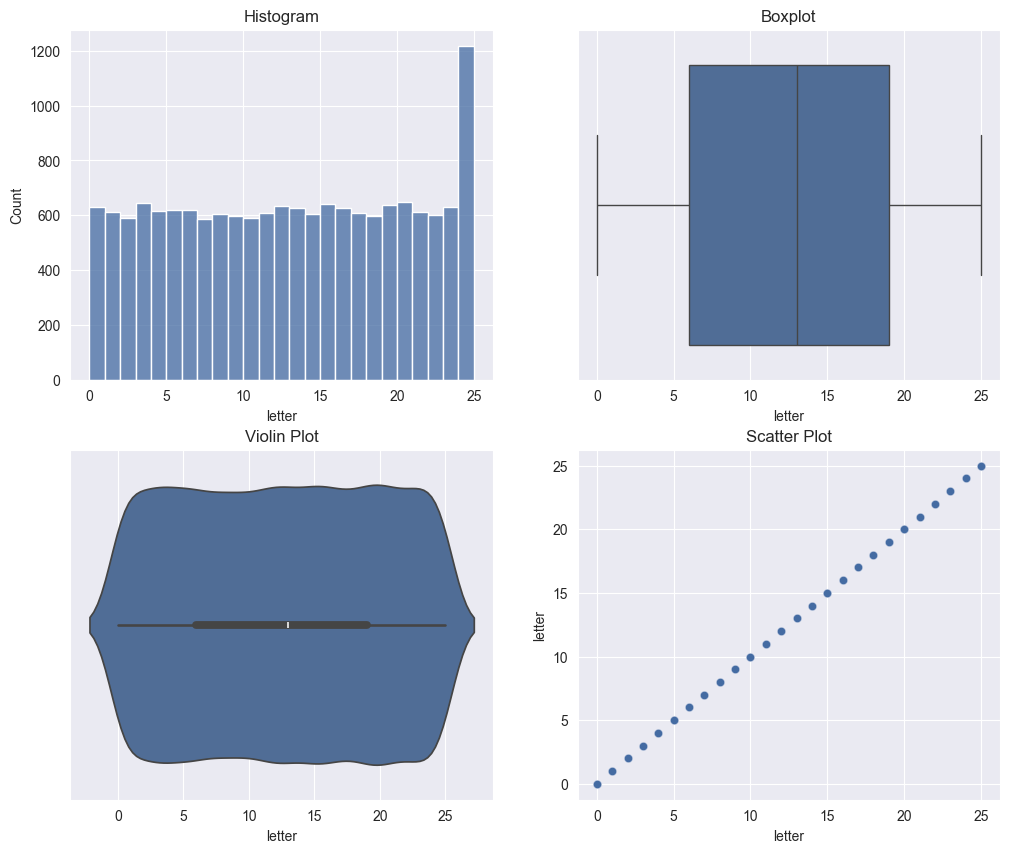

<Figure size 640x480 with 0 Axes>

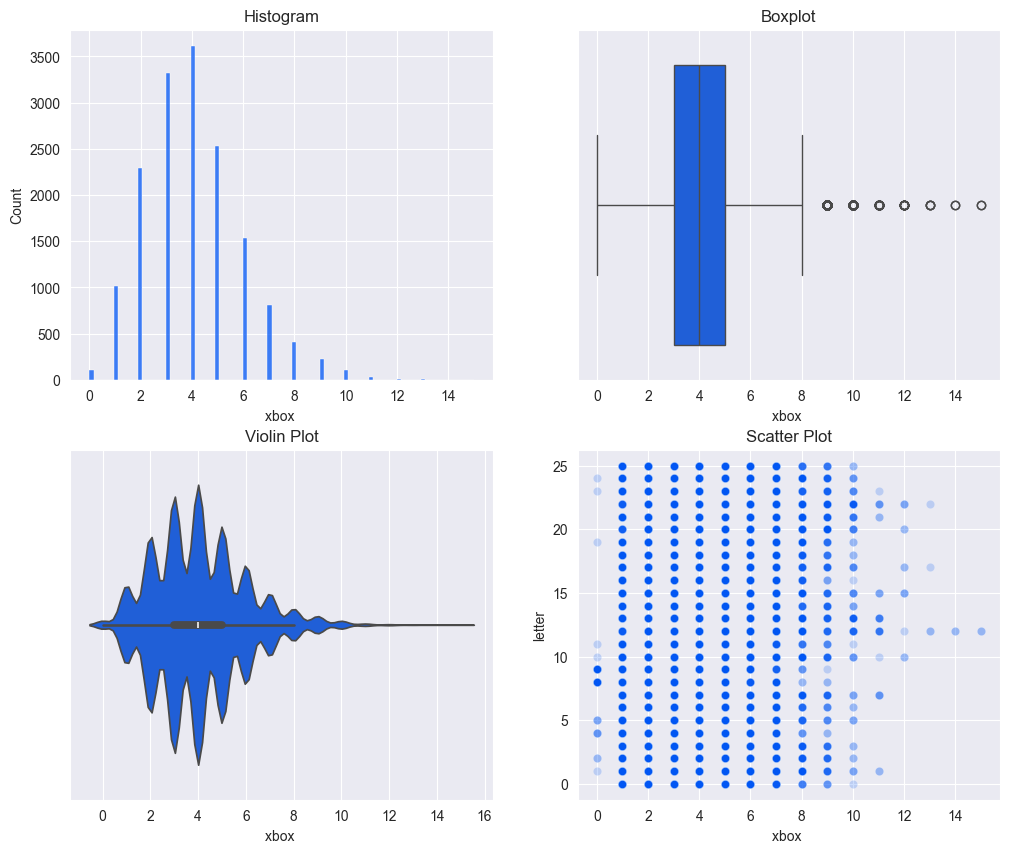

<Figure size 640x480 with 0 Axes>

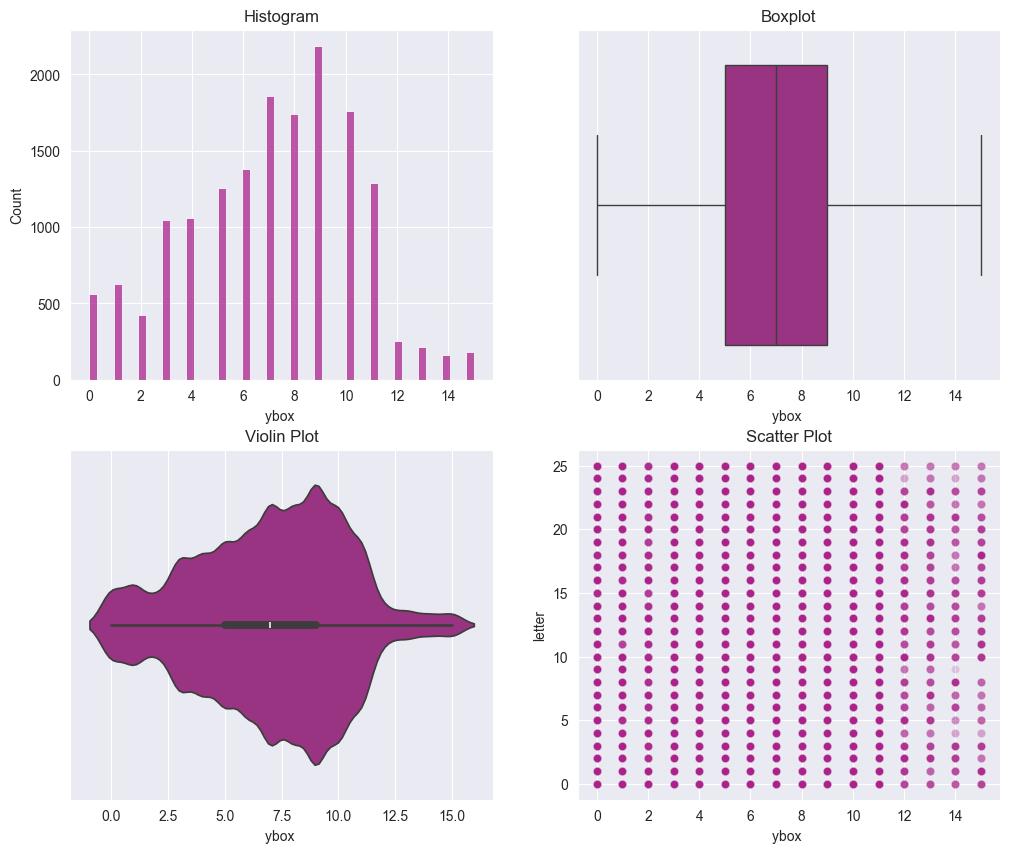

<Figure size 640x480 with 0 Axes>

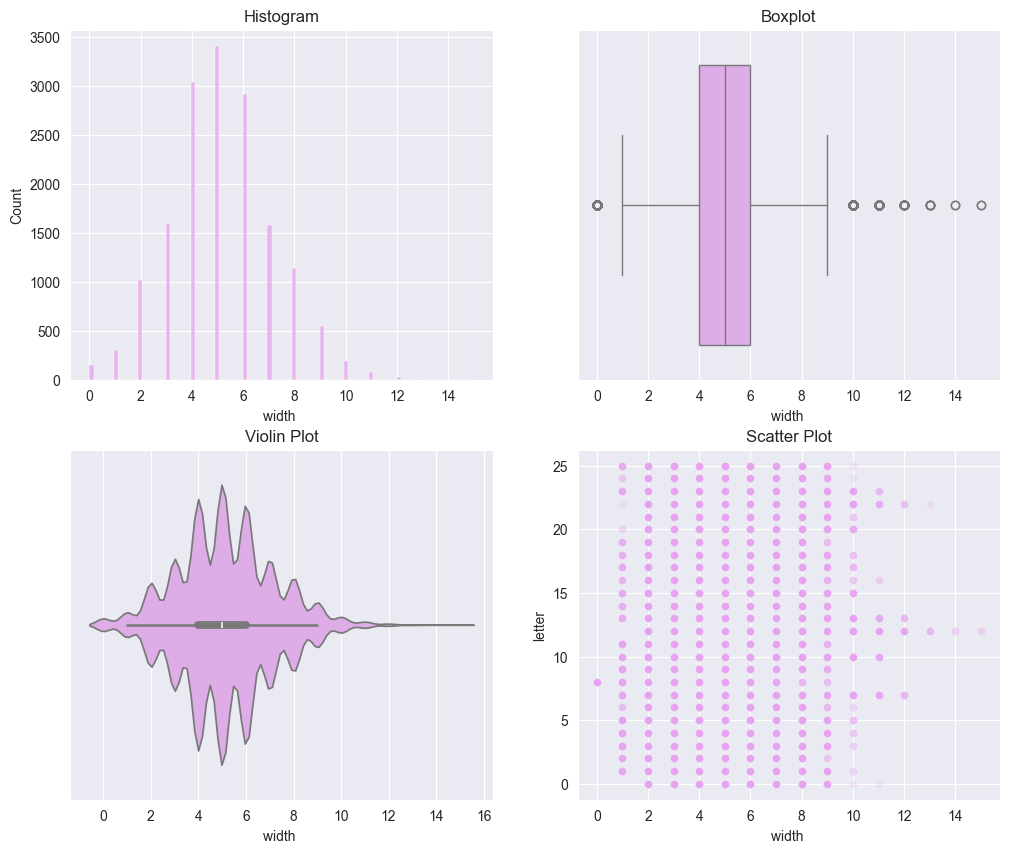

<Figure size 640x480 with 0 Axes>

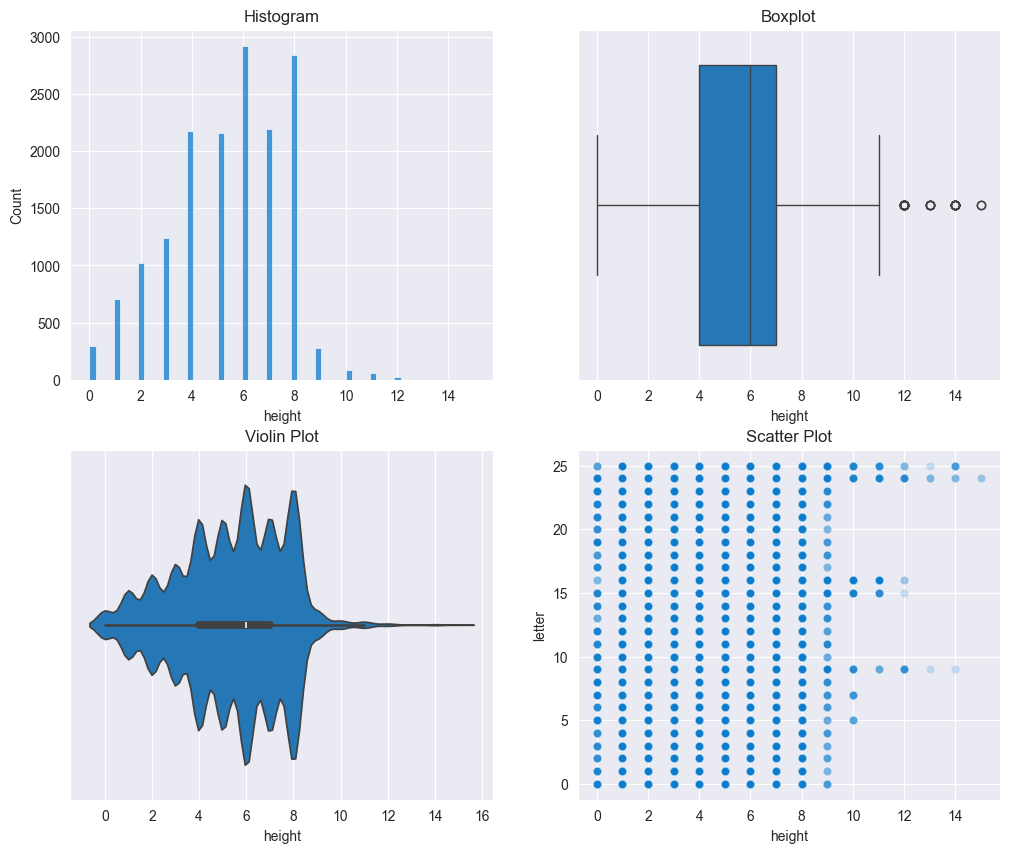

<Figure size 640x480 with 0 Axes>

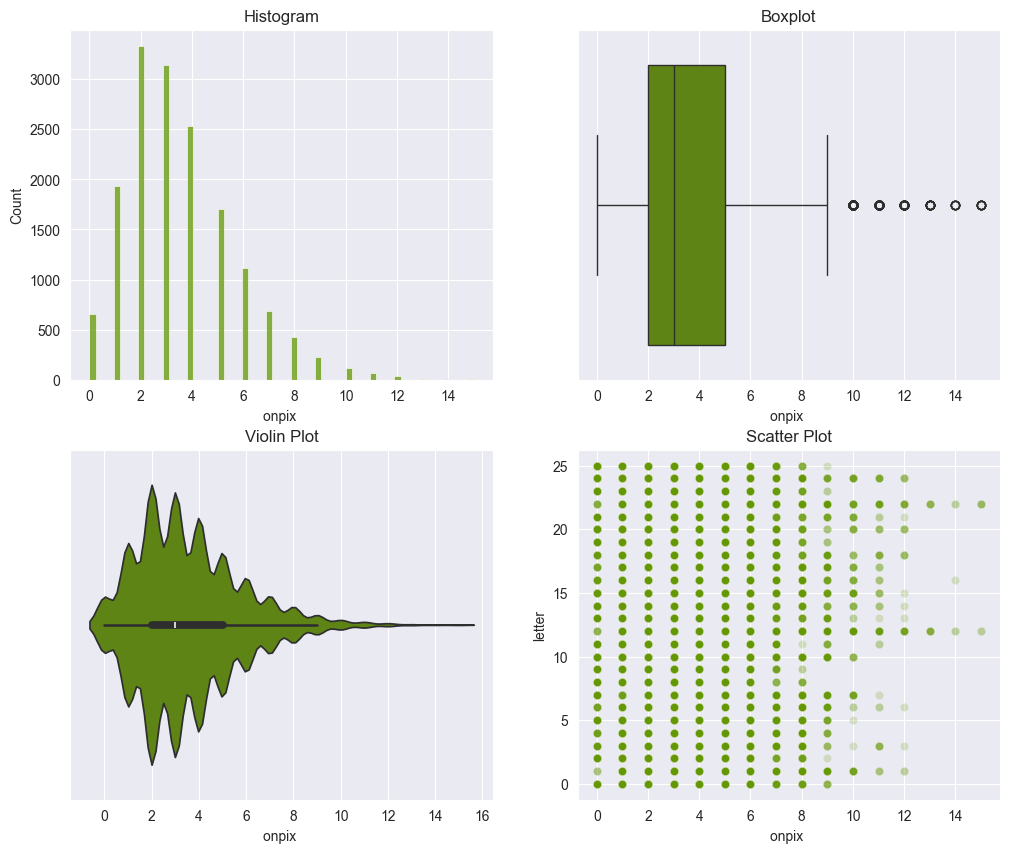

<Figure size 640x480 with 0 Axes>

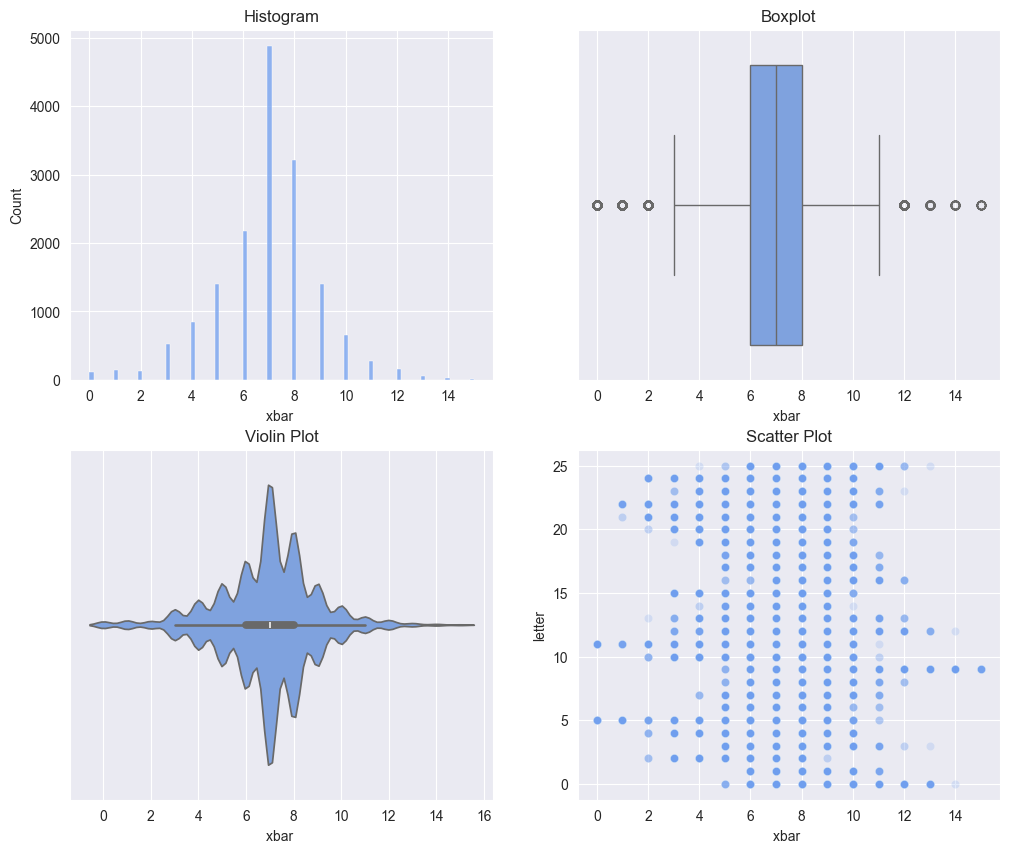

<Figure size 640x480 with 0 Axes>

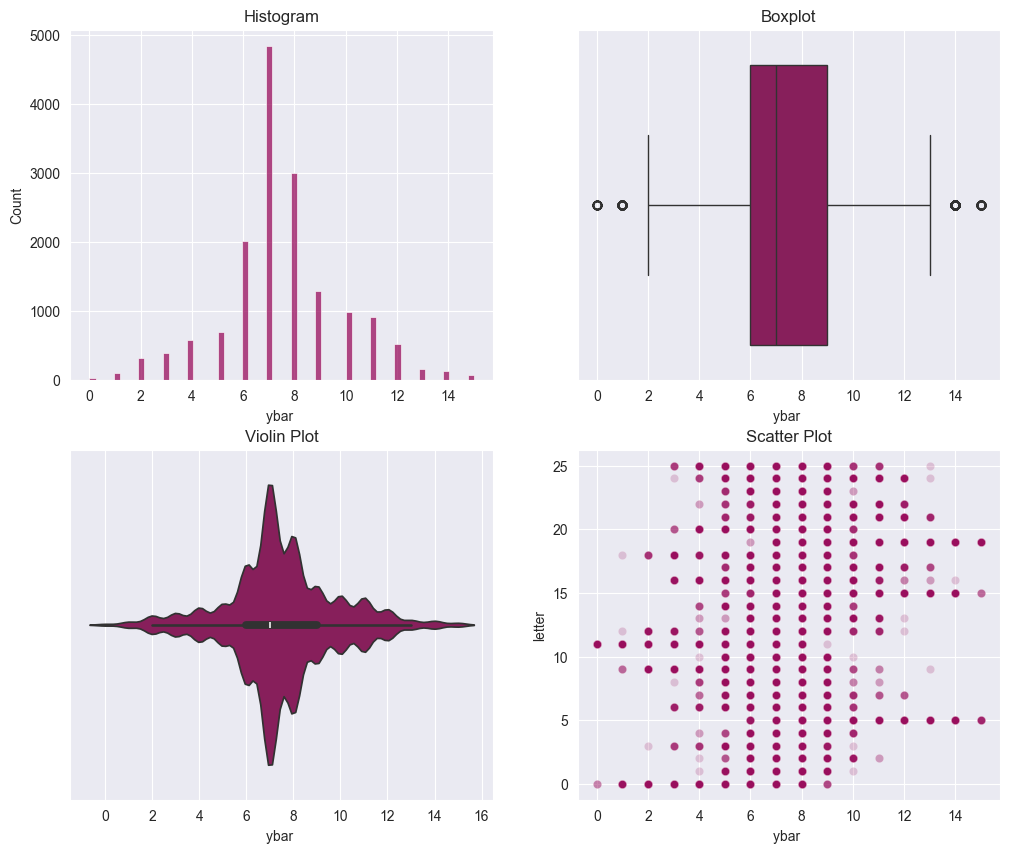

<Figure size 640x480 with 0 Axes>

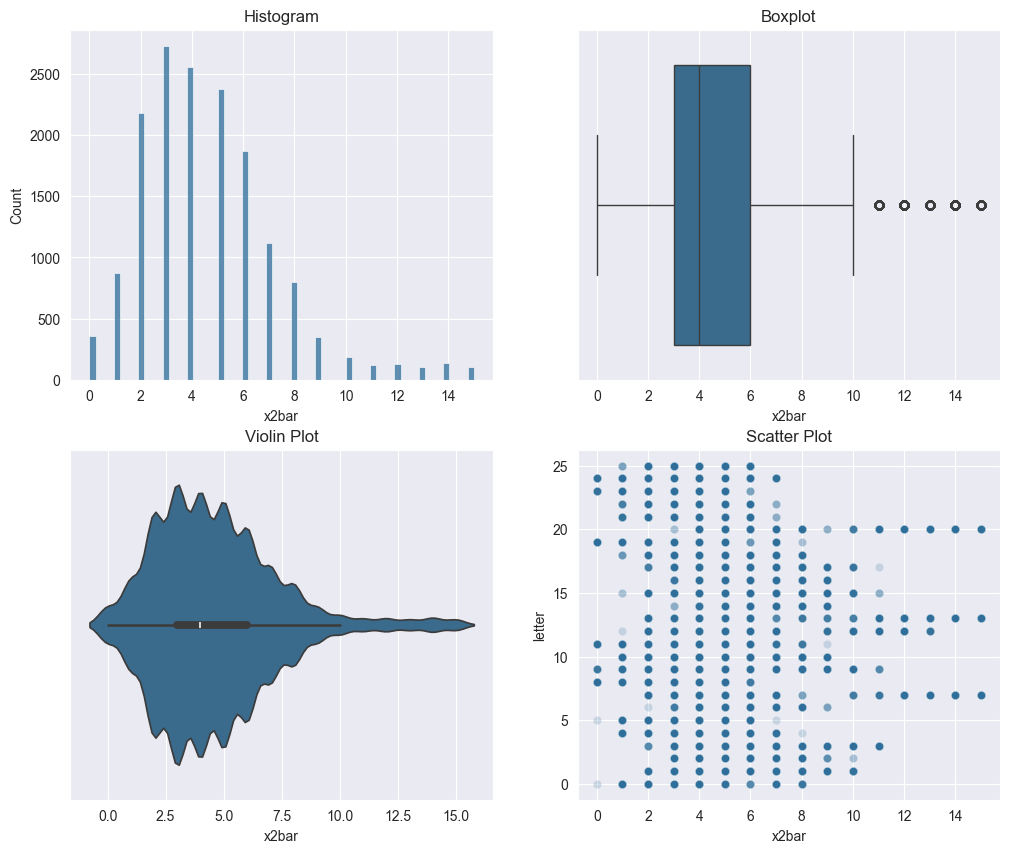

<Figure size 640x480 with 0 Axes>

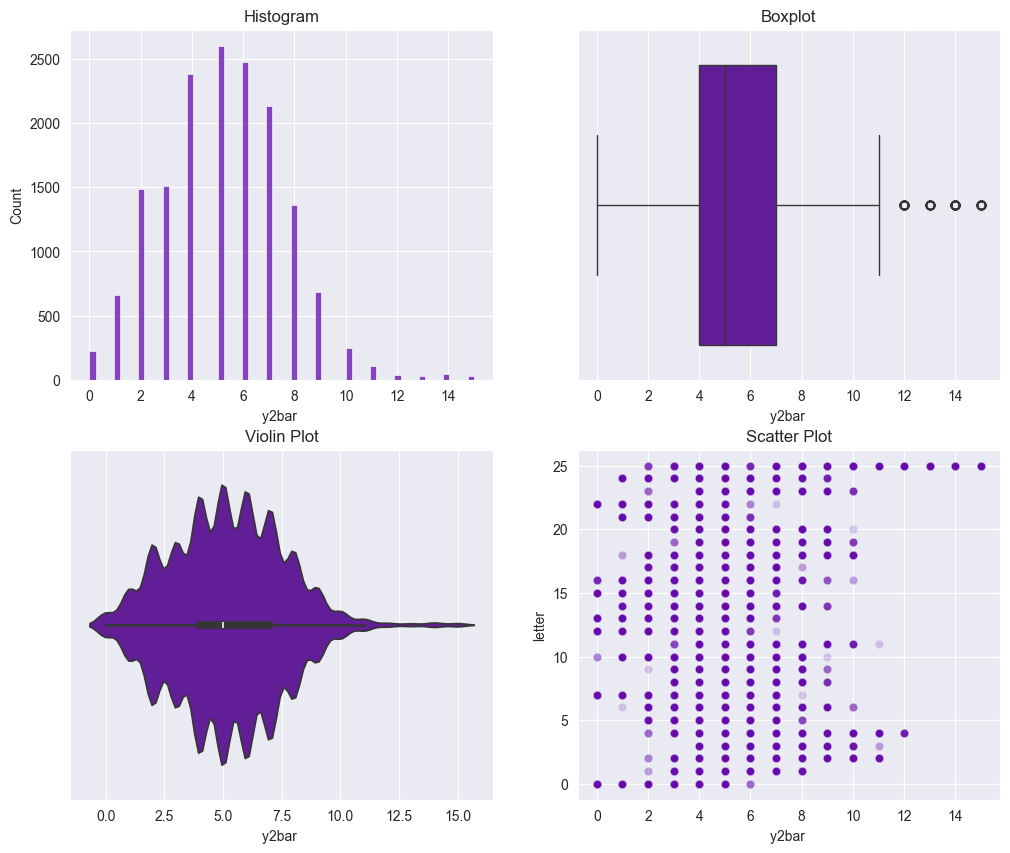

<Figure size 640x480 with 0 Axes>

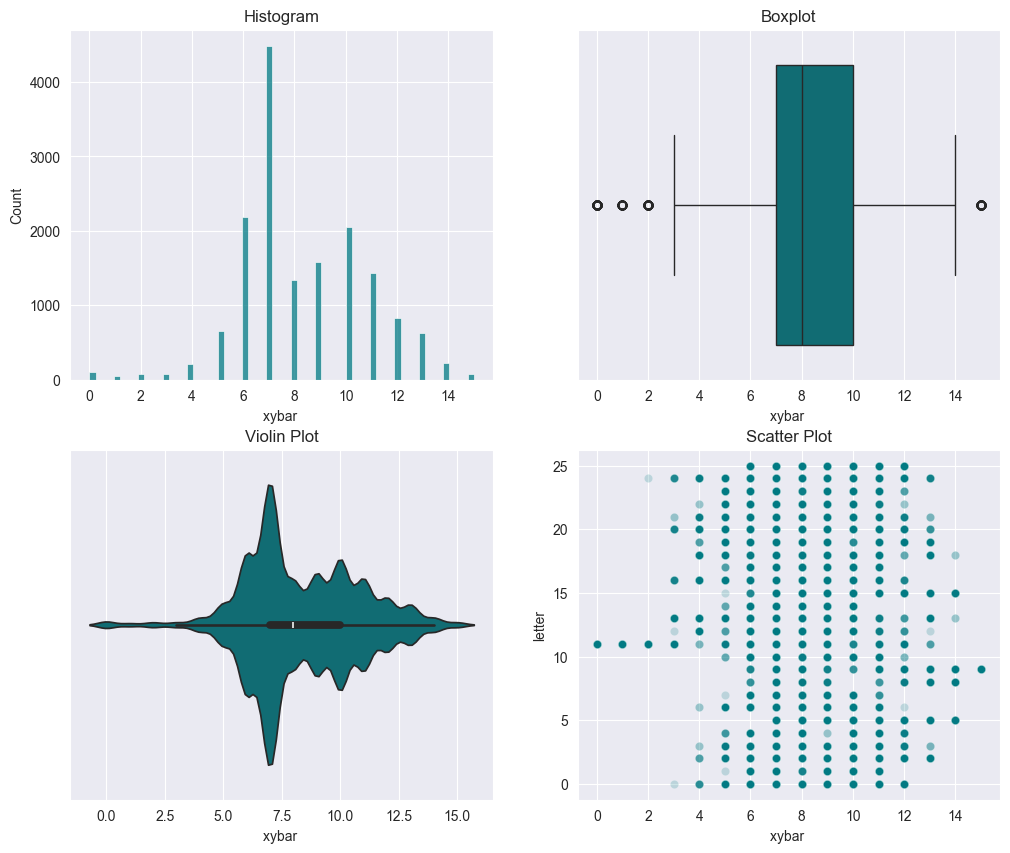

<Figure size 640x480 with 0 Axes>

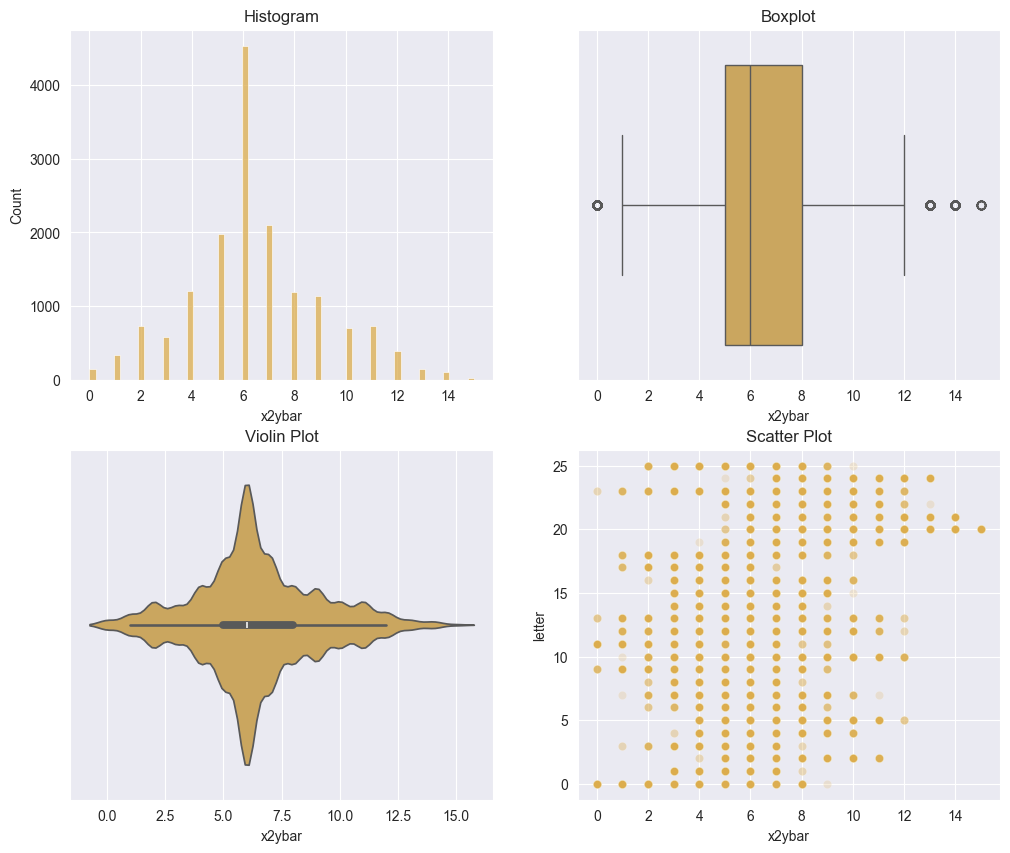

<Figure size 640x480 with 0 Axes>

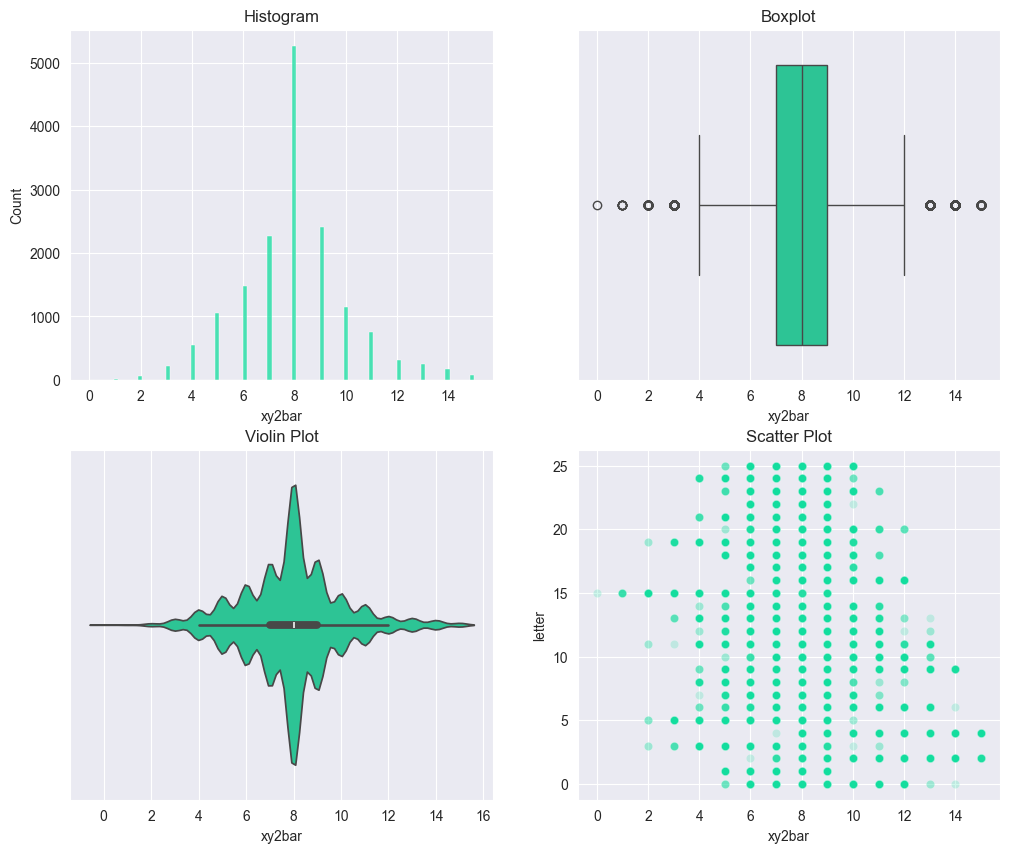

<Figure size 640x480 with 0 Axes>

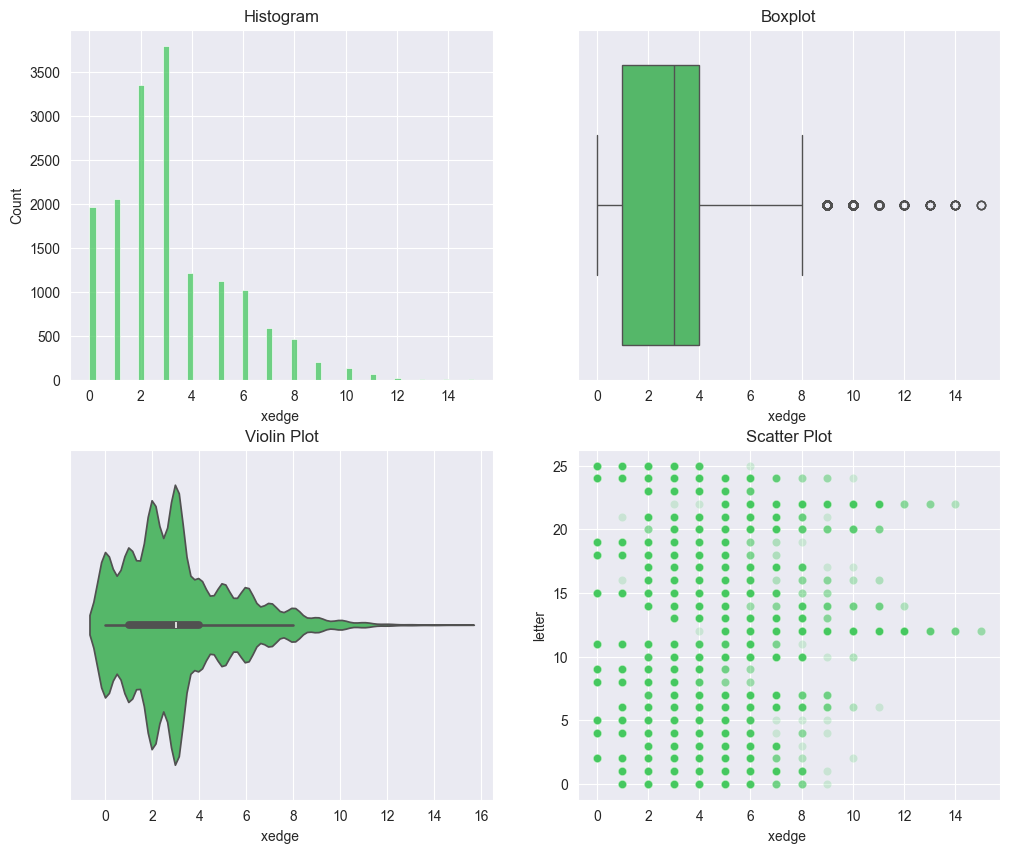

<Figure size 640x480 with 0 Axes>

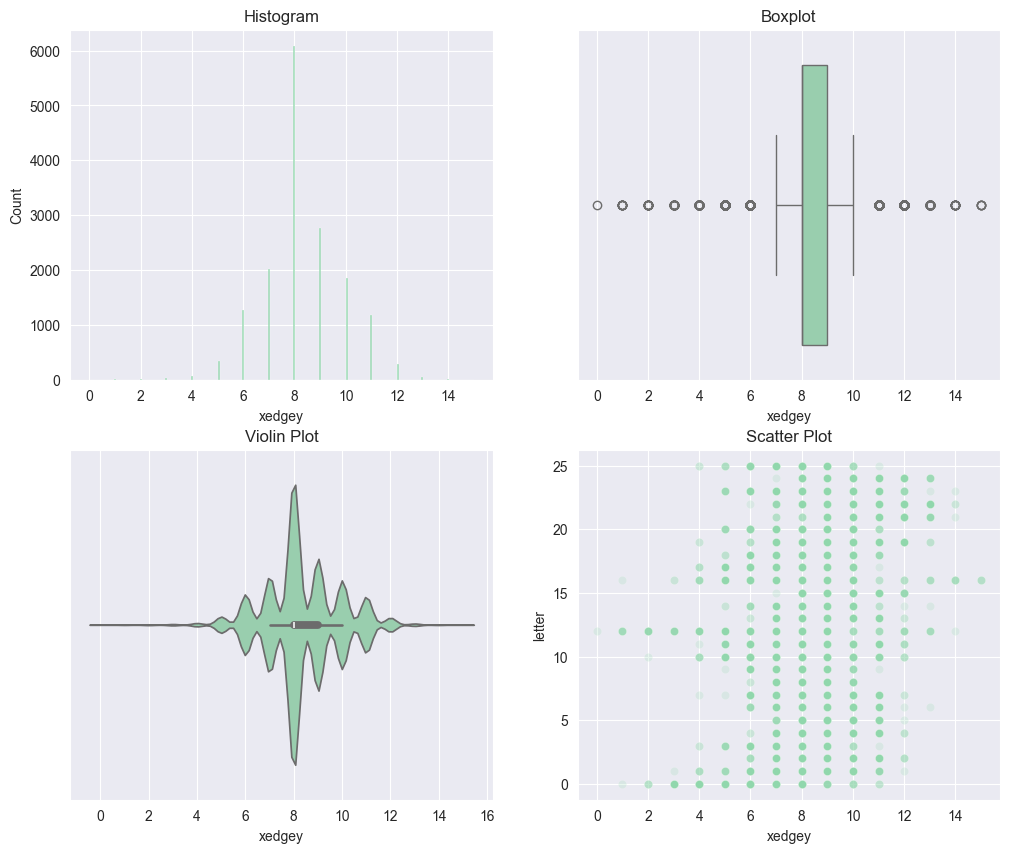

<Figure size 640x480 with 0 Axes>

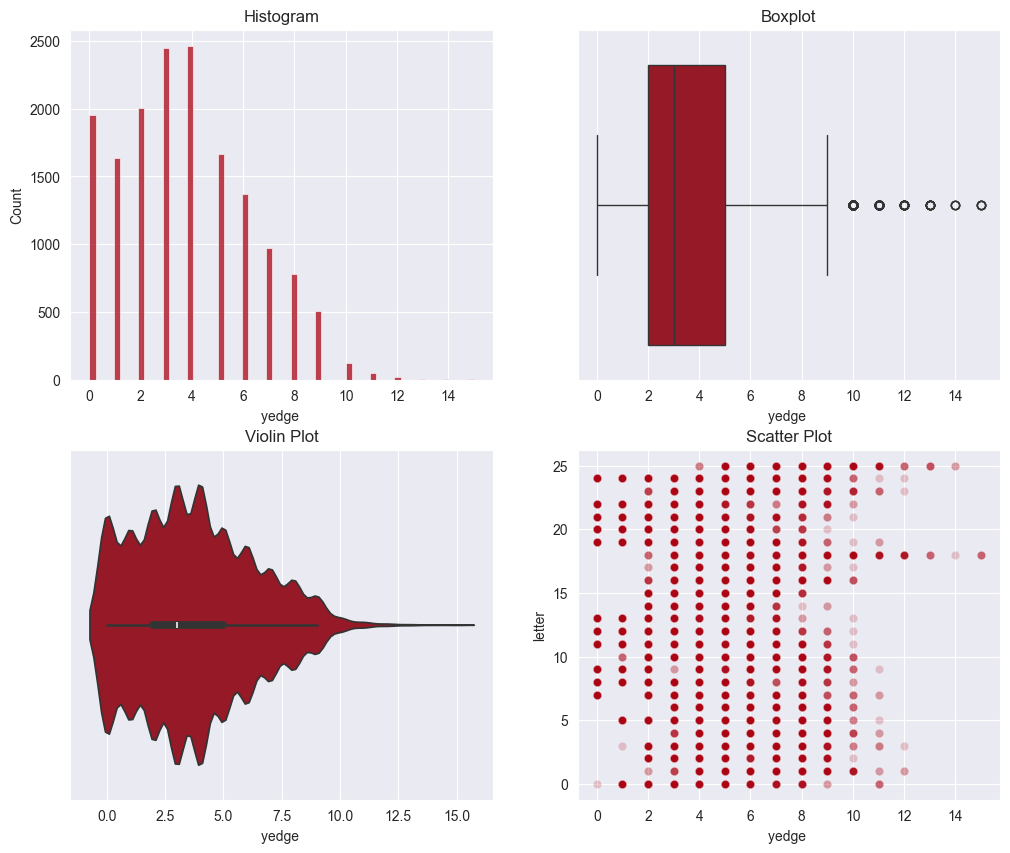

<Figure size 640x480 with 0 Axes>

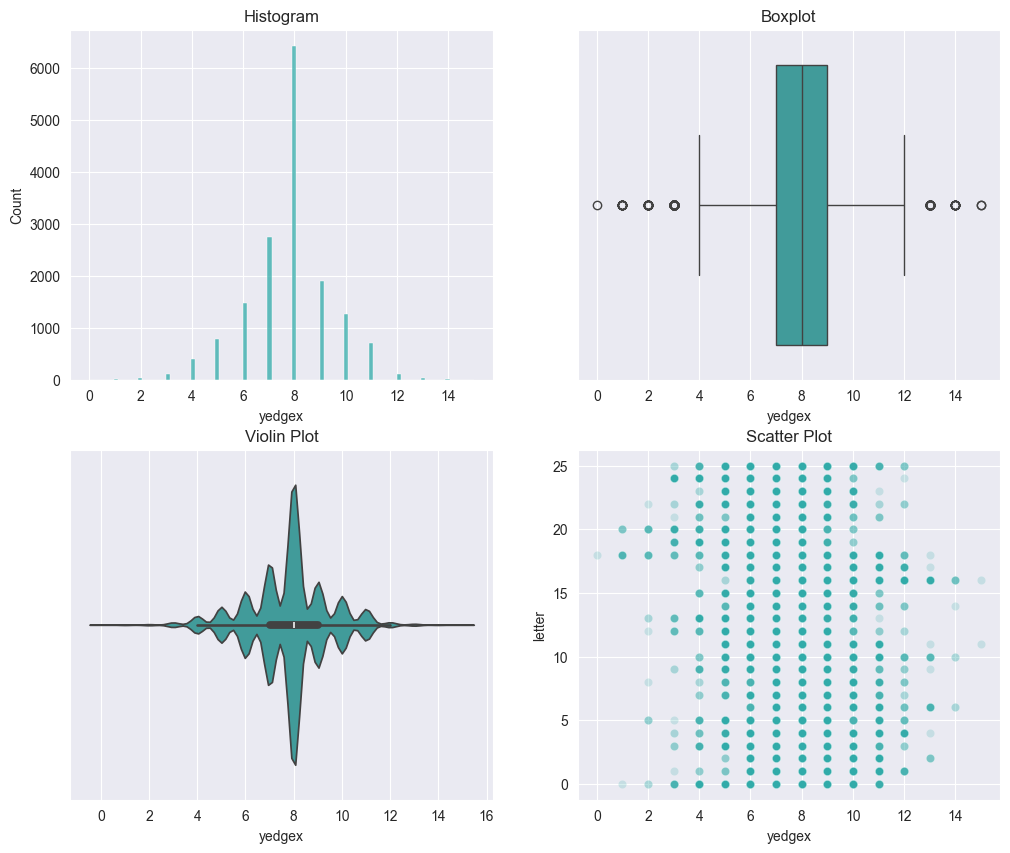

In [12]:
def visualize_attribute(train: pd.DataFrame, attribute: str) -> None:
    plt.figure(facecolor='darkblue')
    color = np.random.rand(3,)
    _, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    sns.histplot(data=train, x=attribute, kde=False, ax=axes[0, 0], color=color)
    axes[0, 0].set_title('Histogram')
    
    sns.boxplot(data=train, x=attribute, ax=axes[0, 1], color=color)
    axes[0, 1].set_title('Boxplot')
    
    sns.violinplot(data=train, x=attribute, ax=axes[1, 0], color=color)
    axes[1, 0].set_title('Violin Plot')
    
    sns.scatterplot(data=train, x=attribute, y='letter', ax=axes[1, 1], color=color, alpha=0.2)
    axes[1, 1].set_title('Scatter Plot')
    
    plt.show()

attributes = list(df.keys())
for attribute in attributes:
    visualize_attribute(train, attribute)

- Neki opis podataka

## Standardizacija

**SVM radi bolje sa standardizovanim podacima**
- Primenimo standardizaciju (izuzev labele) nad svim promenljivama i opet prikazemo rezultate

In [13]:
feature_scalers = {}
train_scaled = train.copy()
for attribute in df.columns:
    if attribute == 'letter':
        continue
    scaler = StandardScaler()
    scaler.fit(df[[attribute]])
    feature_scalers[attribute] = scaler
    train_scaled[attribute] = scaler.transform(train_scaled[[attribute]])
    train_scaled[attribute] = train_scaled[attribute].astype(np.float16)

<Figure size 640x480 with 0 Axes>

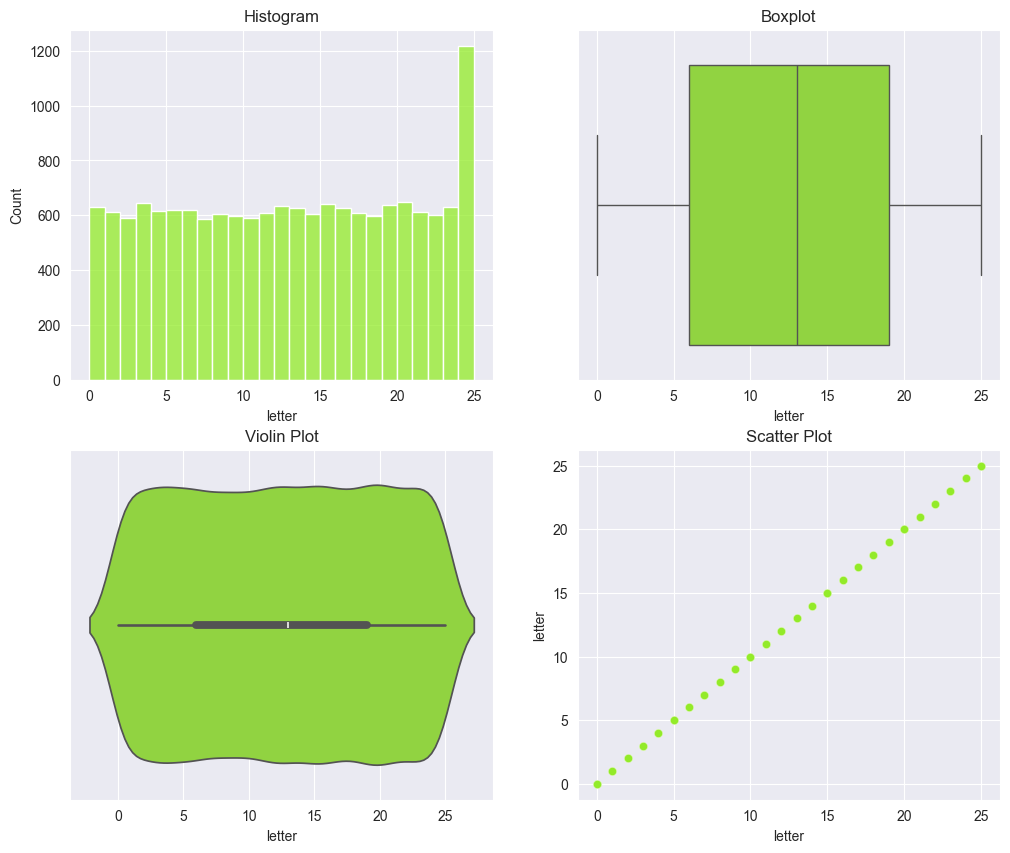

<Figure size 640x480 with 0 Axes>

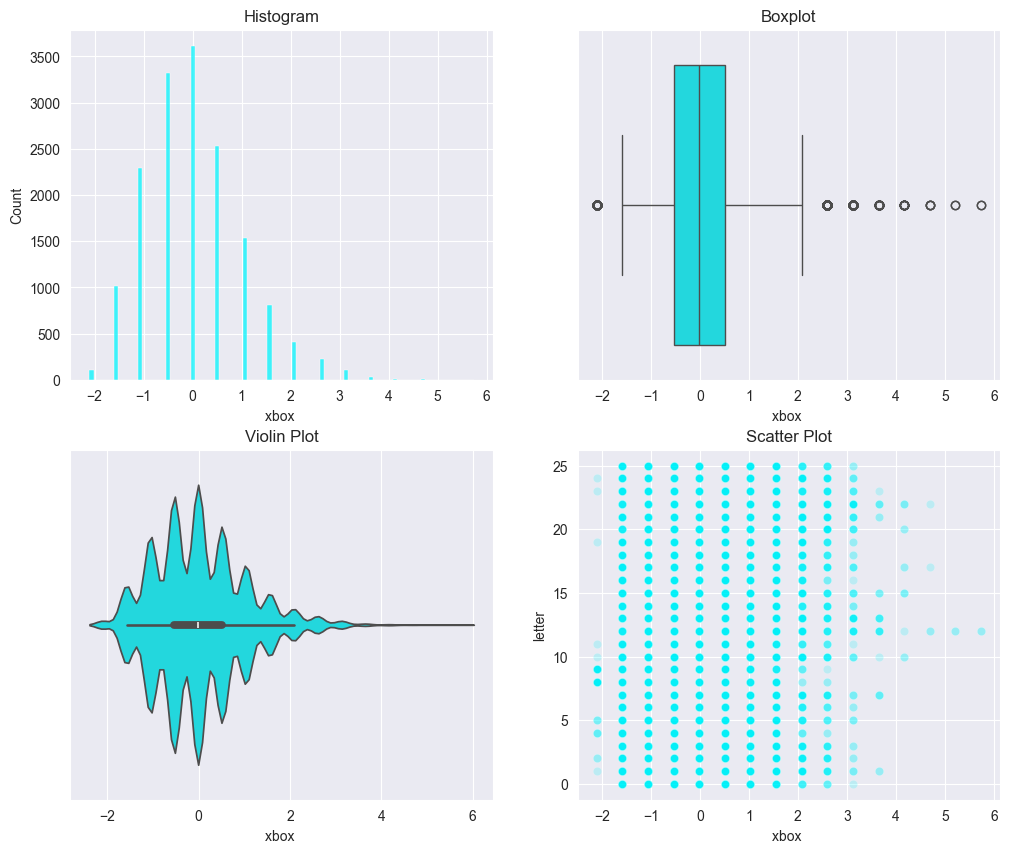

<Figure size 640x480 with 0 Axes>

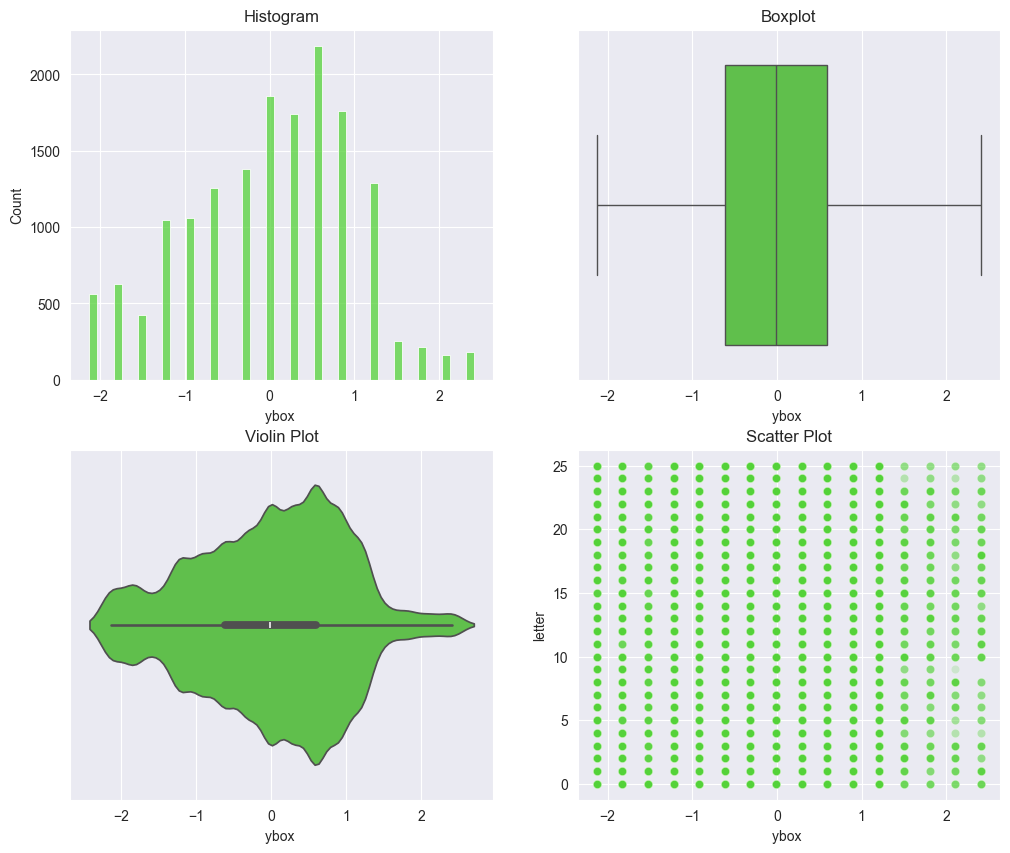

<Figure size 640x480 with 0 Axes>

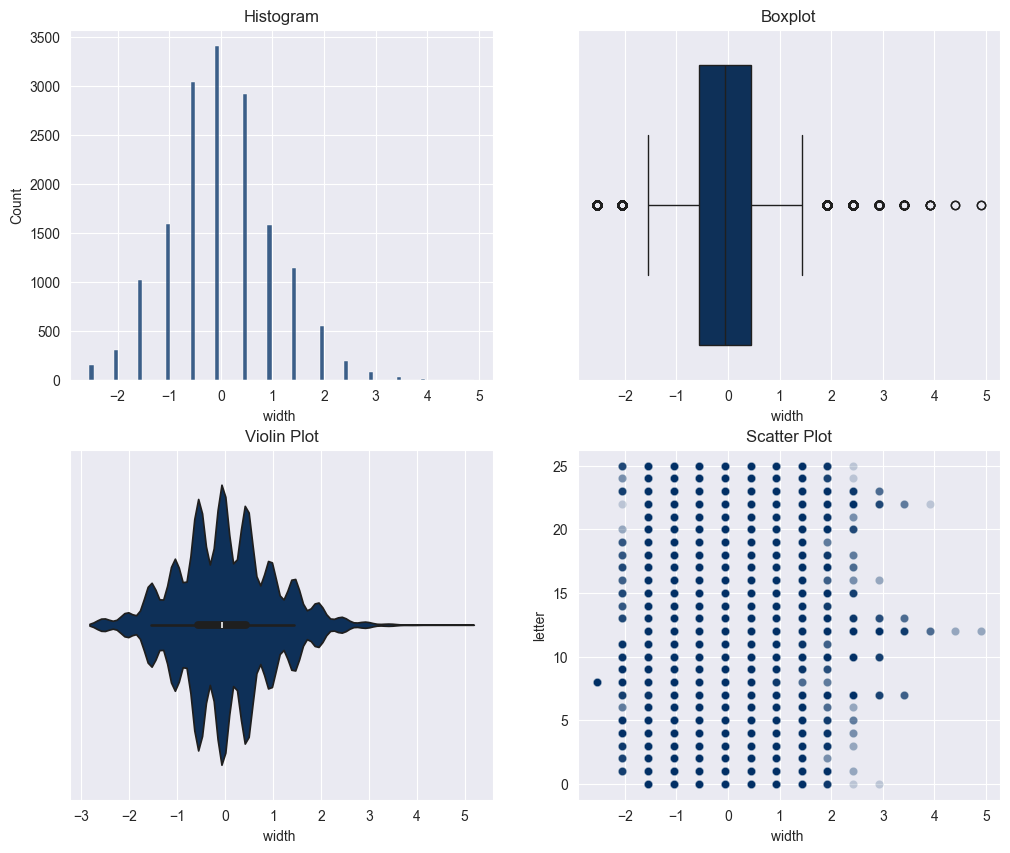

<Figure size 640x480 with 0 Axes>

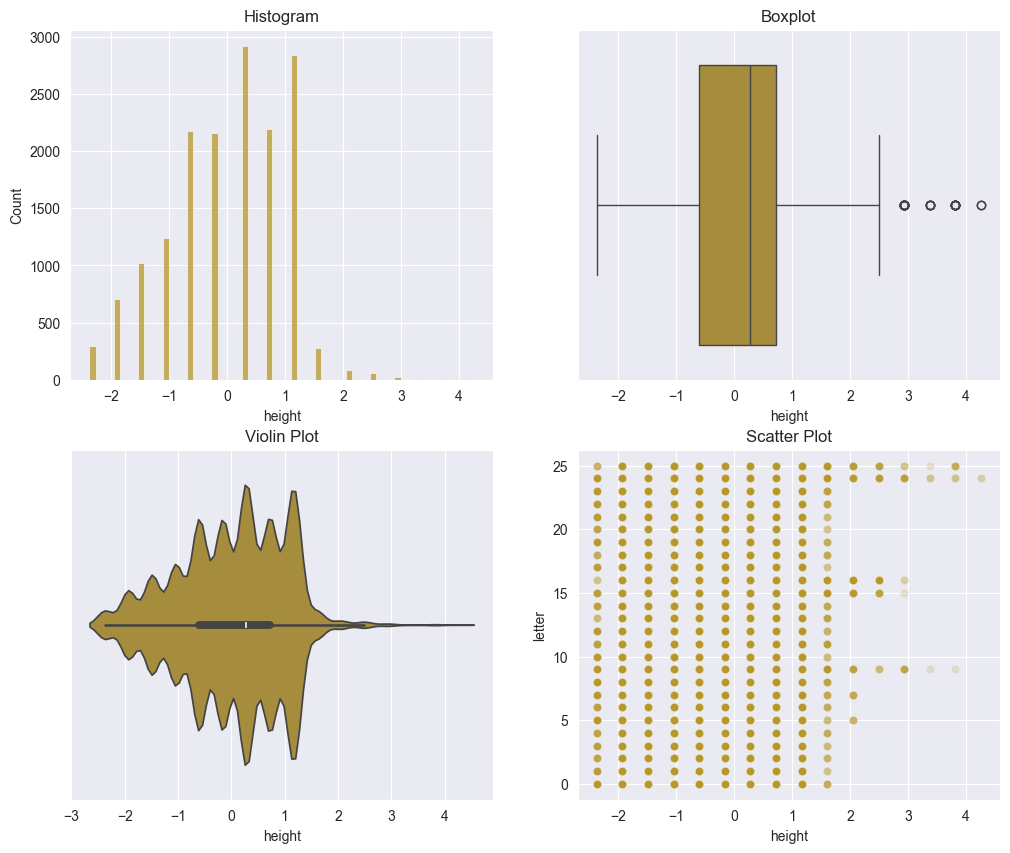

<Figure size 640x480 with 0 Axes>

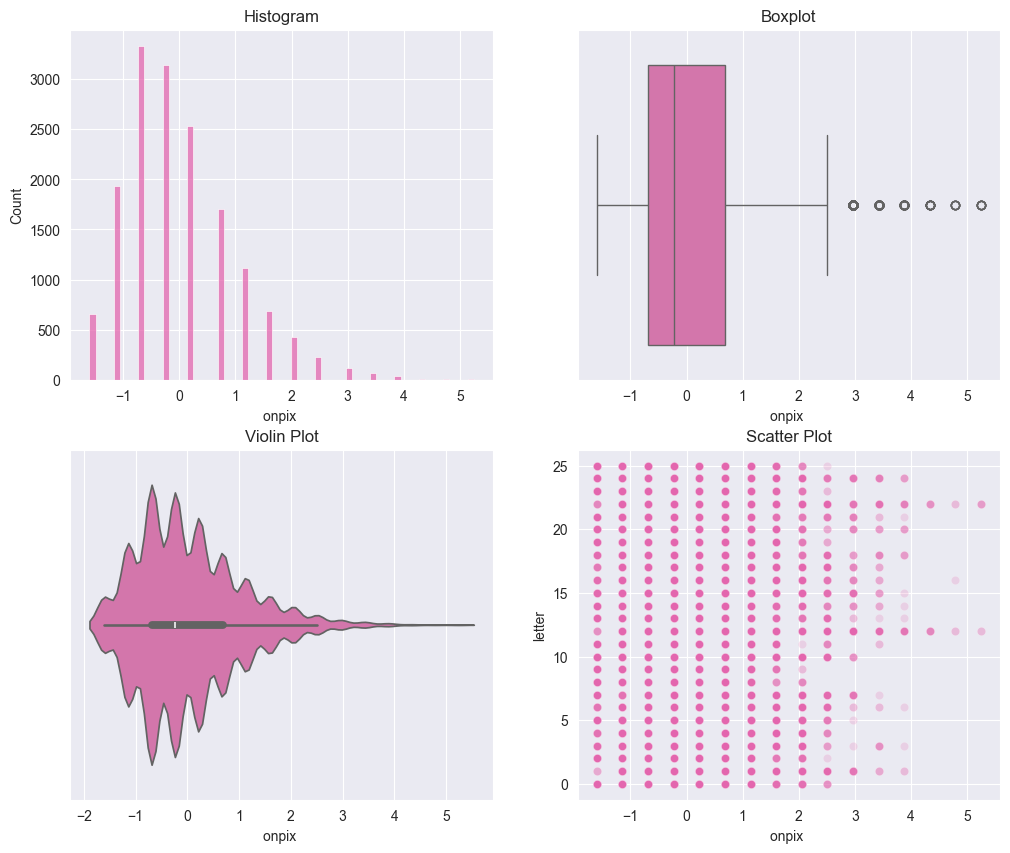

<Figure size 640x480 with 0 Axes>

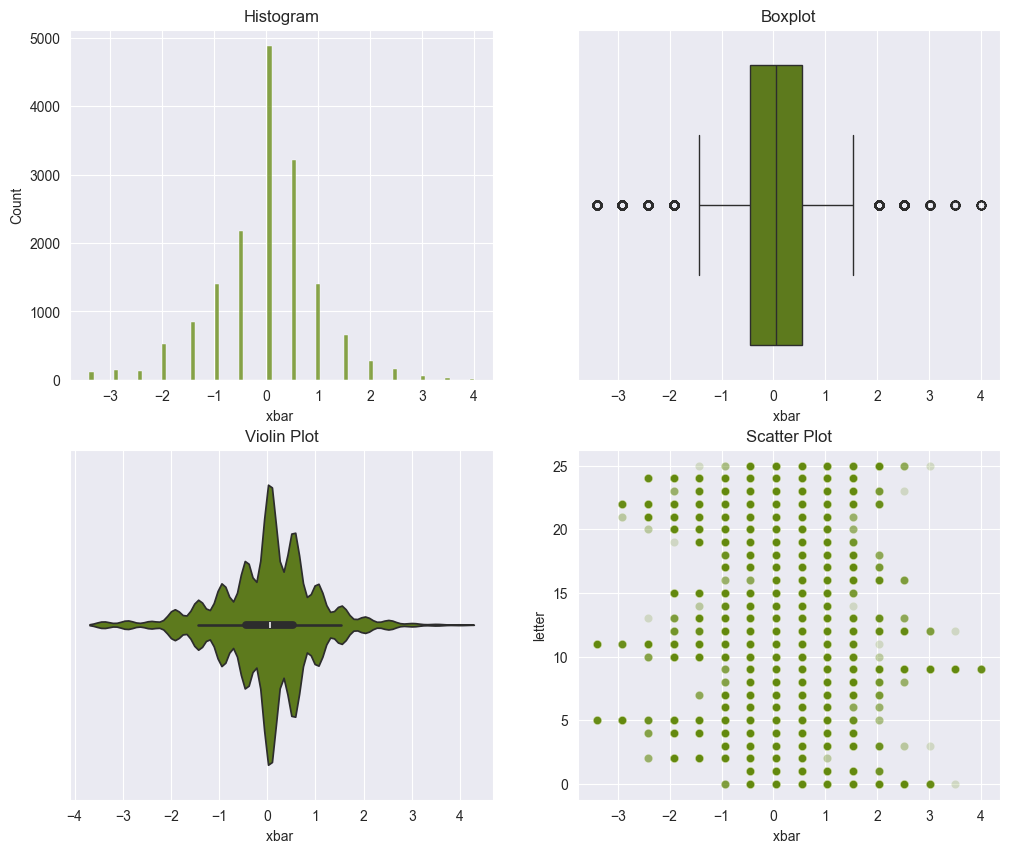

<Figure size 640x480 with 0 Axes>

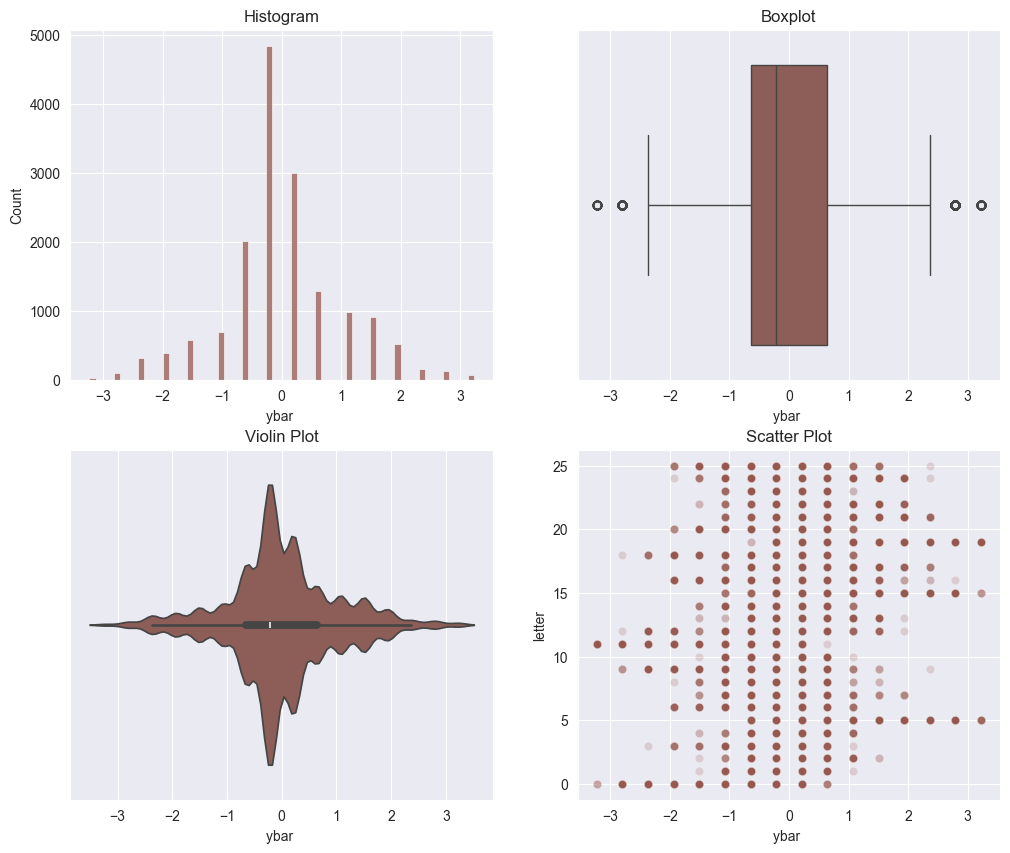

<Figure size 640x480 with 0 Axes>

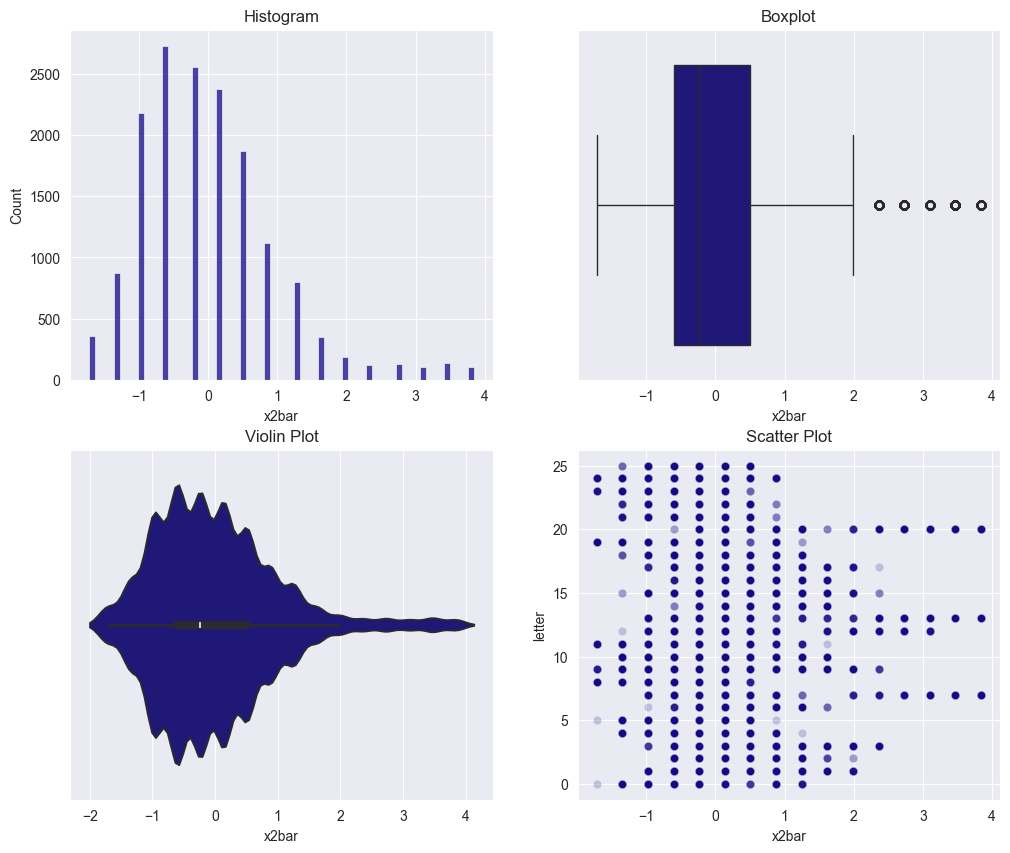

<Figure size 640x480 with 0 Axes>

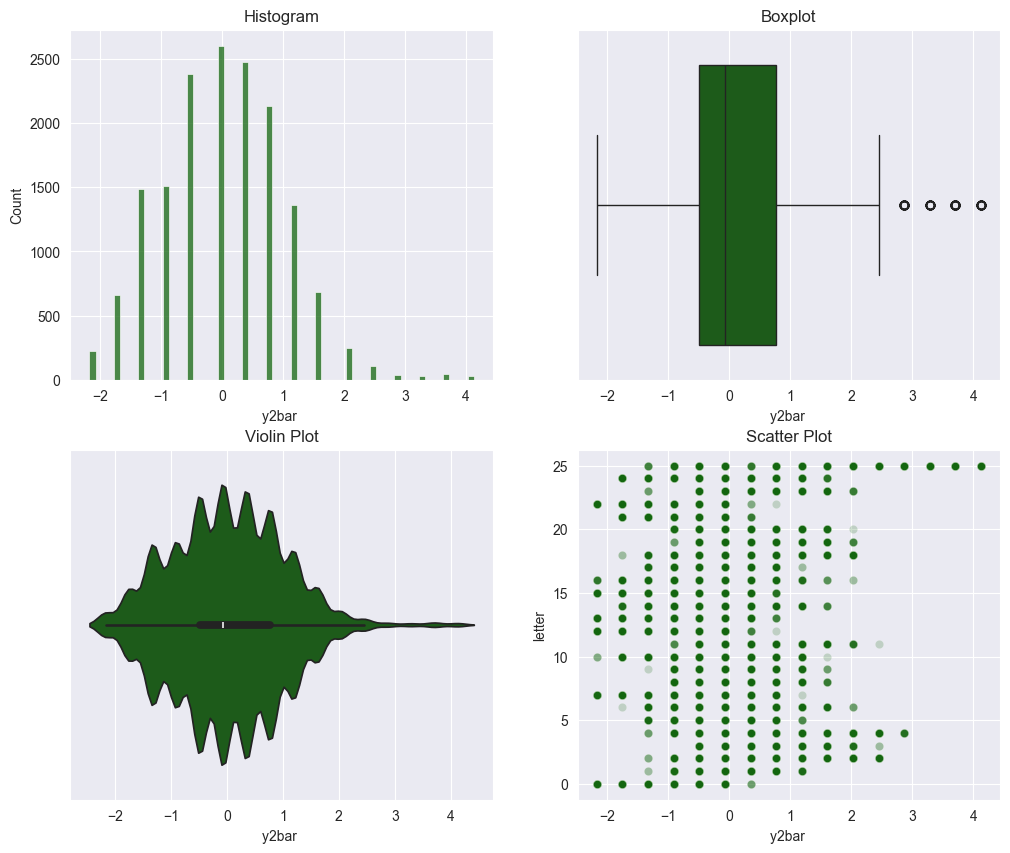

<Figure size 640x480 with 0 Axes>

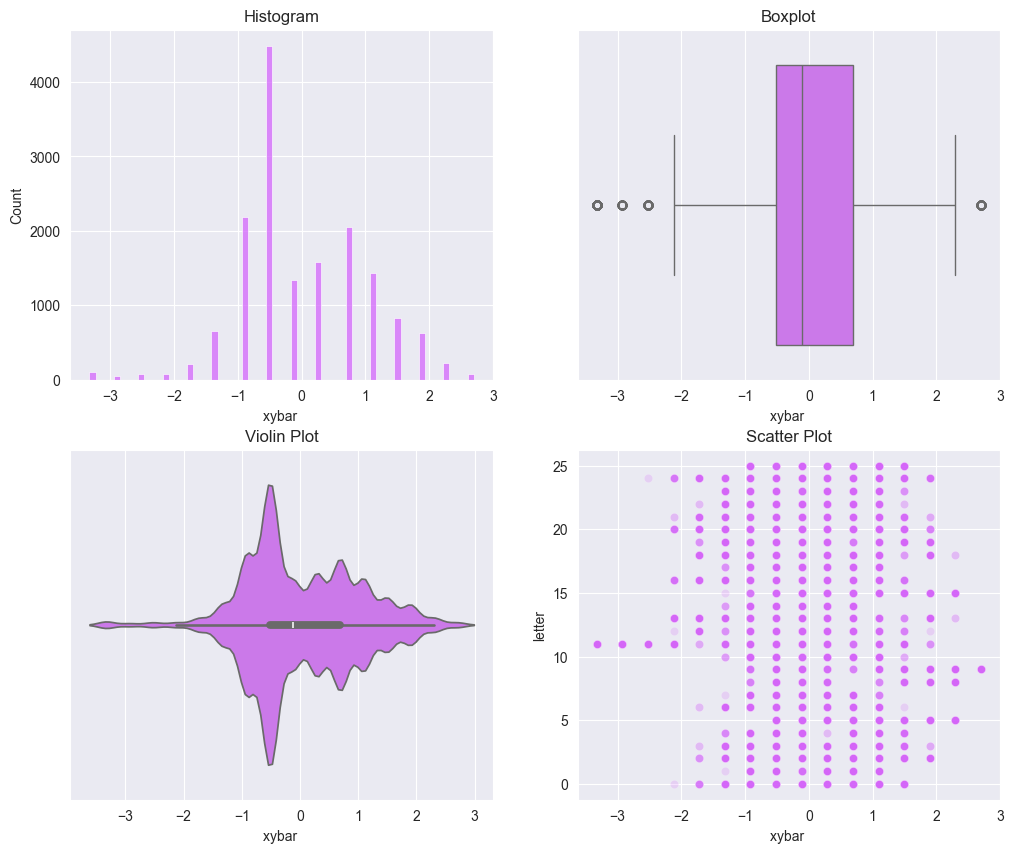

<Figure size 640x480 with 0 Axes>

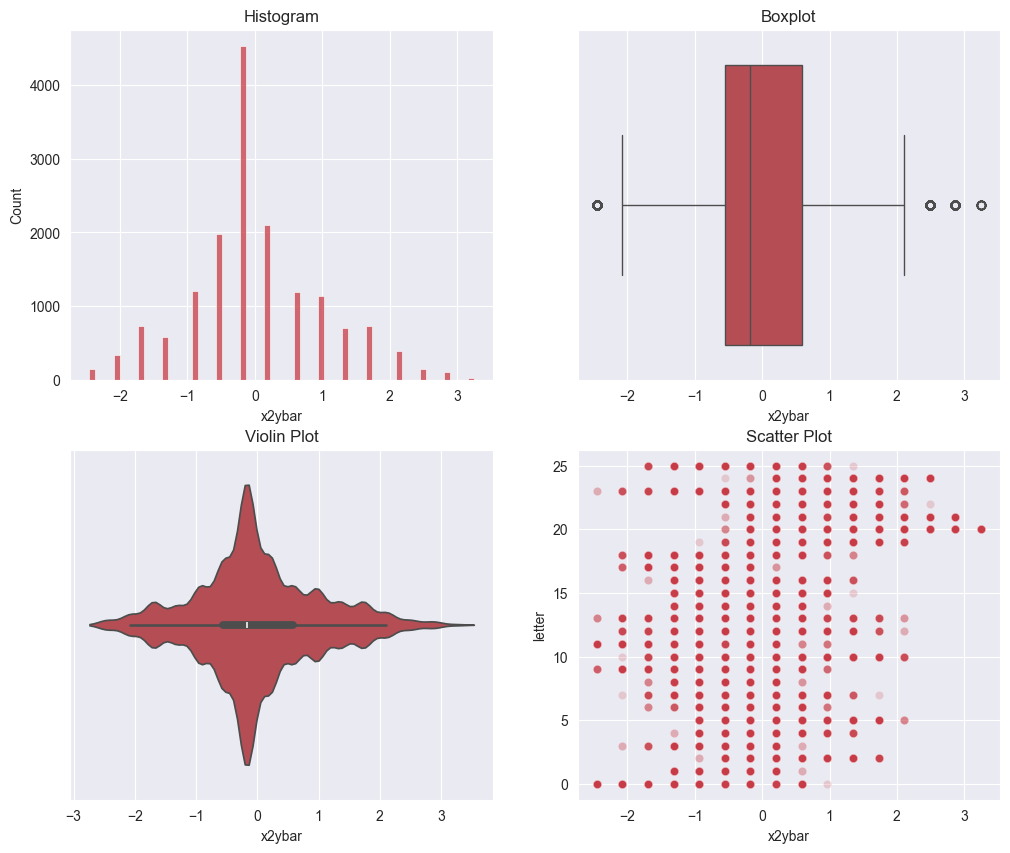

<Figure size 640x480 with 0 Axes>

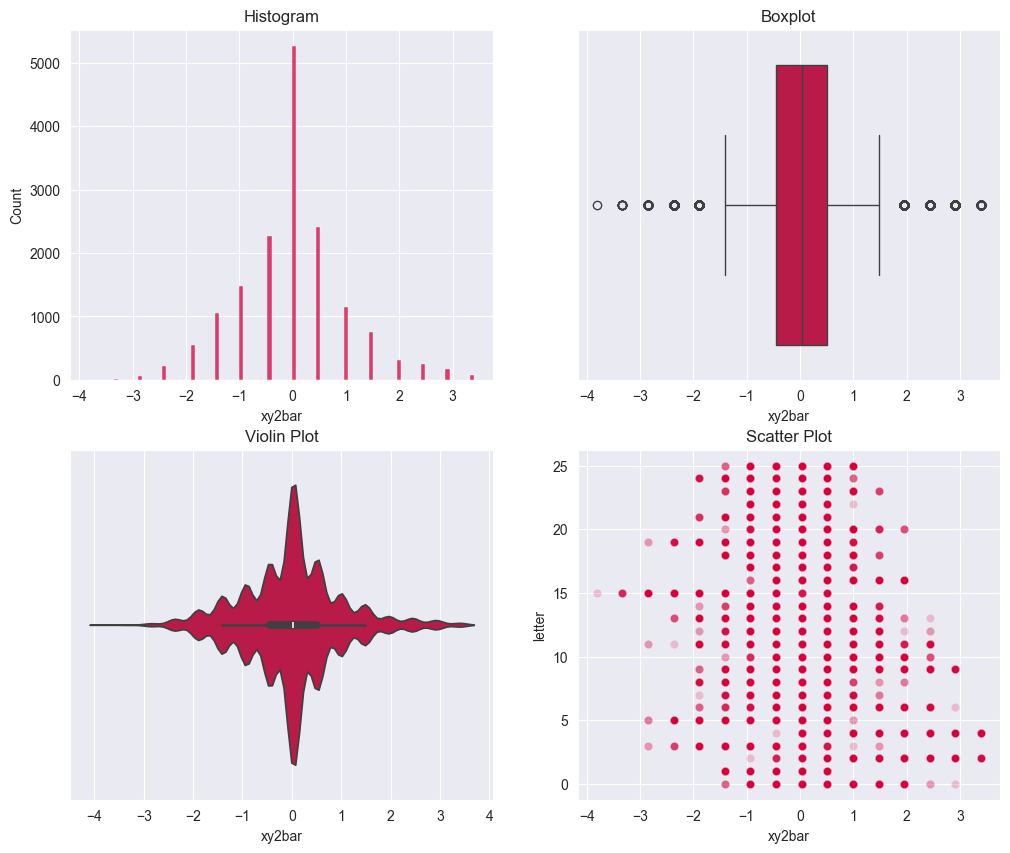

<Figure size 640x480 with 0 Axes>

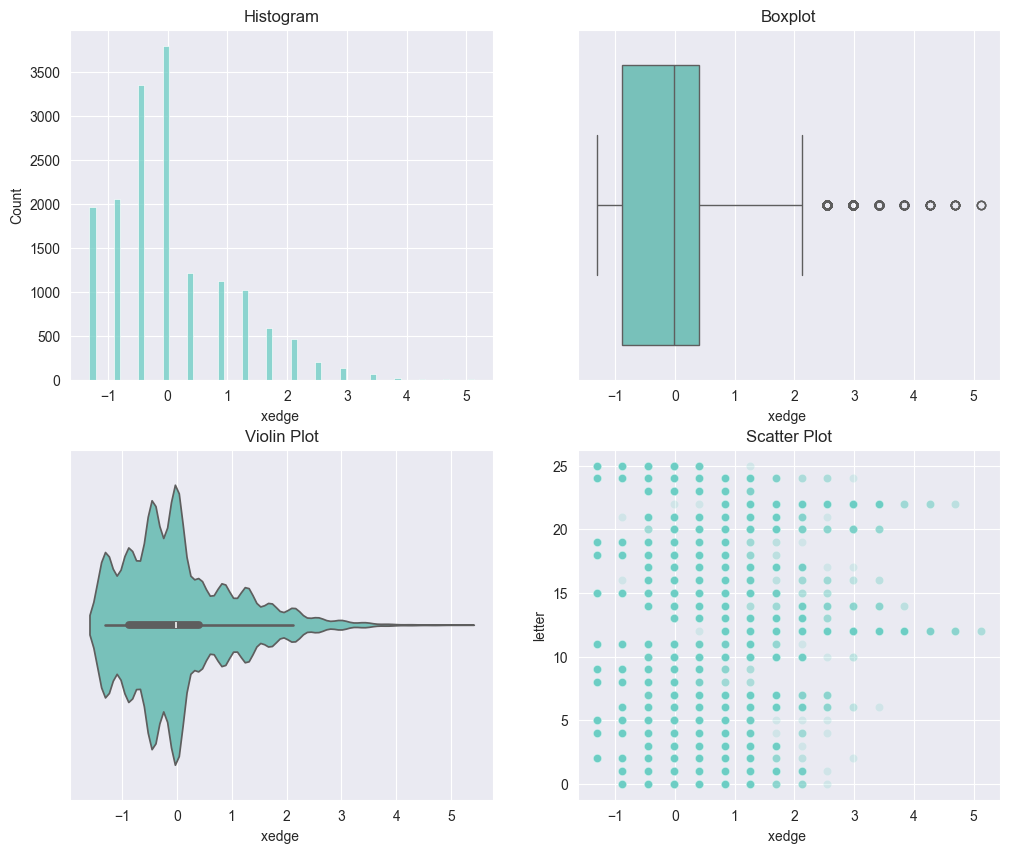

<Figure size 640x480 with 0 Axes>

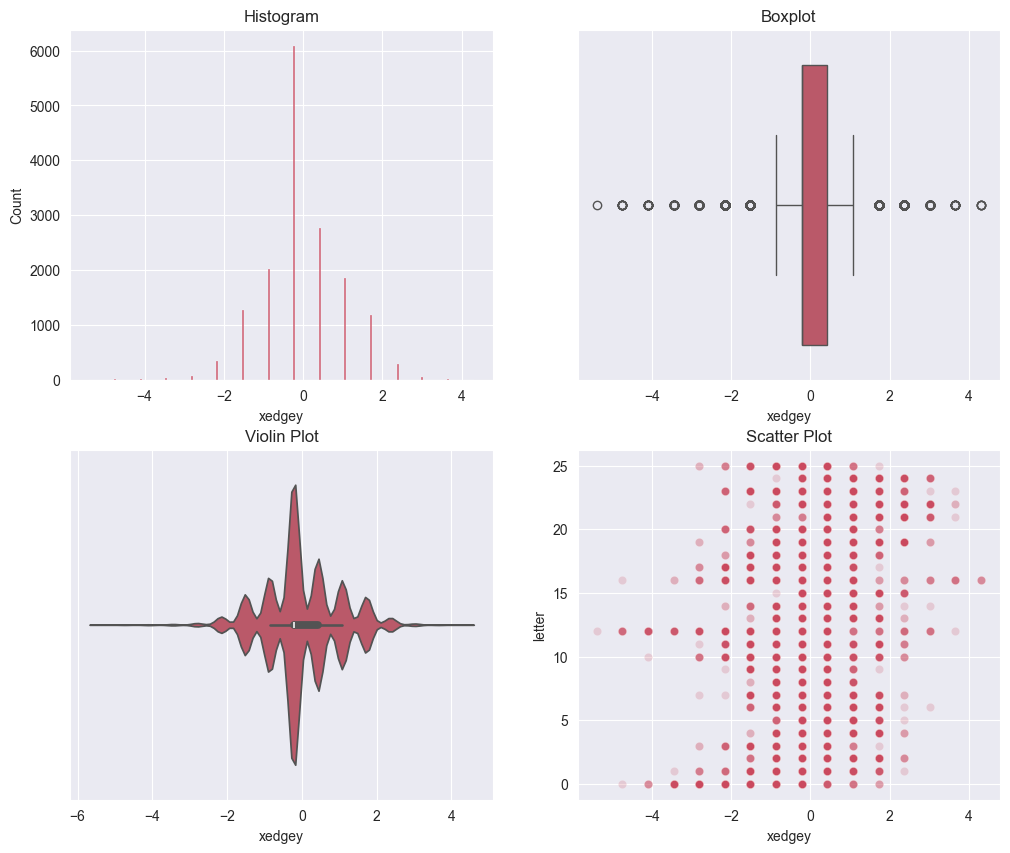

<Figure size 640x480 with 0 Axes>

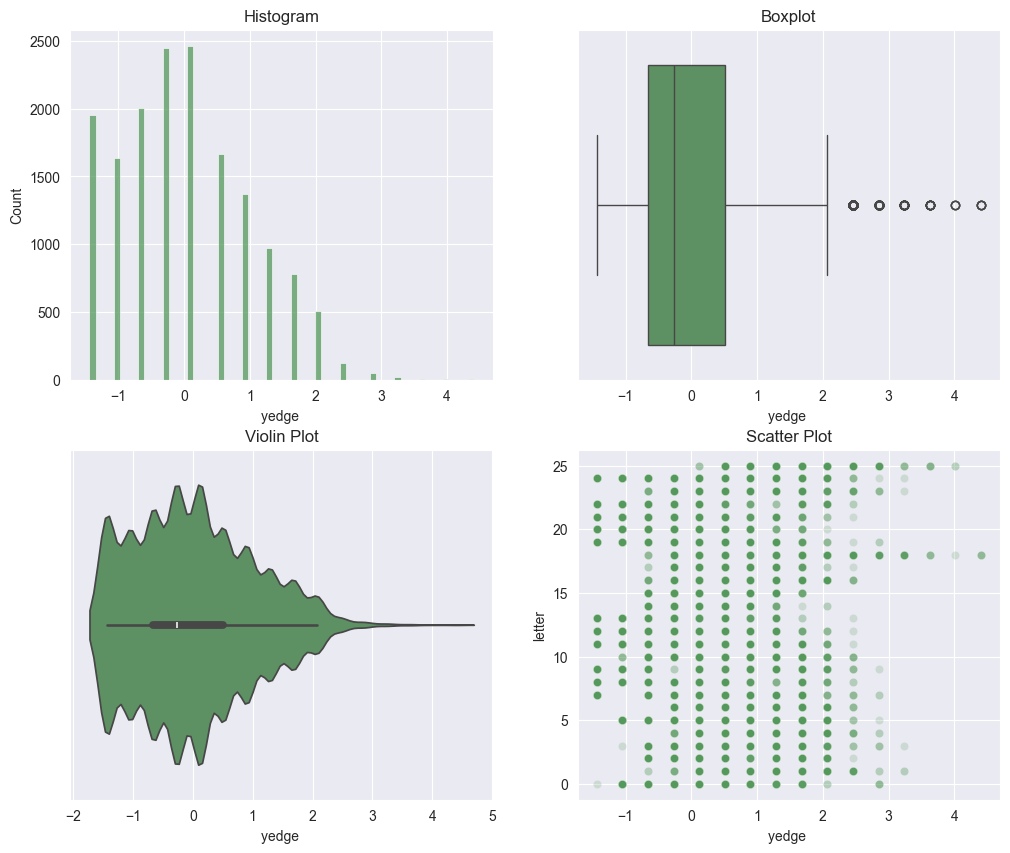

<Figure size 640x480 with 0 Axes>

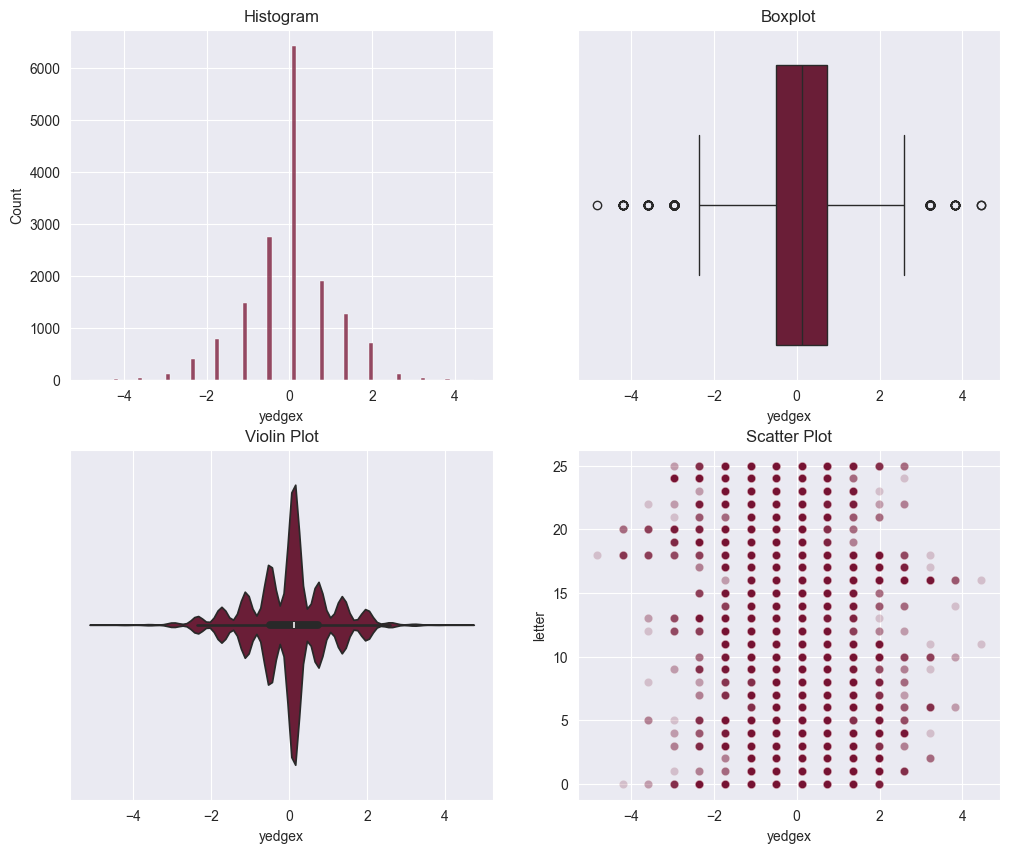

In [14]:
attributes = list(train_scaled.keys())
for attribute in attributes:
    visualize_attribute(train_scaled, attribute)

# Trening

In [15]:
def train_model(X, y, model):
    model.fit(X, y)
    y_pred = model.predict(X)
    
    if hasattr(model, 'predict_proba'):
        y_pred_prob = model.predict_proba(X)
        auc = roc_auc_score(y, y_pred_prob, multi_class='ovr')
    else:
        auc = np.nan
    
    f1 = f1_score(y, y_pred, average='macro')
    precision = precision_score(y, y_pred, average='macro')
    recall = recall_score(y, y_pred, average='macro')

    print(f"Model: {type(model).__name__}")
    print(f"AUC: {auc:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()
    

In [16]:
y_train = train['letter']
train.drop(['letter'], inplace=True, axis=1)

C:\Users\Danilo\AppData\Local\Temp\ipykernel_13384\627905441.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(['letter'], inplace=True, axis=1)


In [17]:
svc = SVC()

Model: SVC
AUC: nan
F1: 0.9374
Precision: 0.9397
Recall: 0.9369


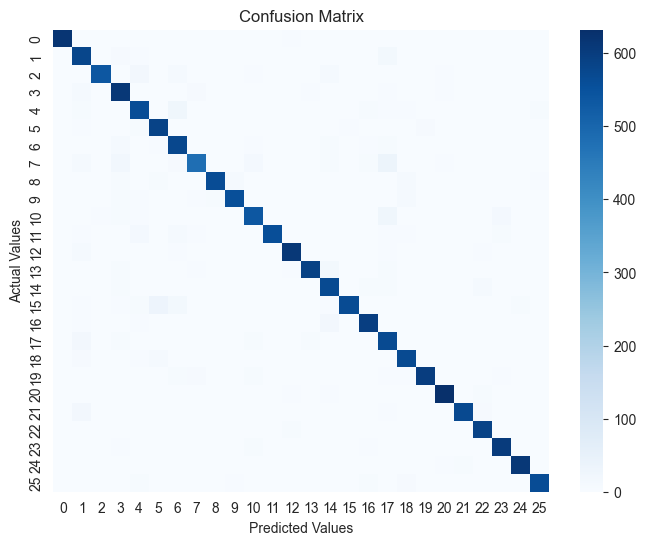

In [18]:
train_model(train, y_train, svc)

# Tune

In [19]:
def train_test_model(X, y, model, param_grid, result_df, tag=None):
    train_y = y.values.ravel()  # Flatten y to be a 1D array
    f1_scorer = make_scorer(f1_score, average='macro')

    halving_search = HalvingGridSearchCV(model, param_grid, scoring=f1_scorer, n_jobs=-1, cv=3, verbose=1)
    halving_search.fit(X, train_y)
    
    best_model = halving_search.best_estimator_
    
    y_pred = best_model.predict(X)
    
    if hasattr(best_model, 'predict_proba'):
        y_pred_prob = best_model.predict_proba(X)
        auc = roc_auc_score(train_y, y_pred_prob, multi_class='ovr')
    else:
        auc = np.nan
    
    f1 = f1_score(train_y, y_pred, average='macro')
    precision = precision_score(train_y, y_pred, average='macro')
    recall = recall_score(train_y, y_pred, average='macro')

    print(f"Model: {type(model).__name__}")
    print(f"AUC: {auc:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Best Params: {halving_search.best_params_}")
    
    tag = "_" + tag if tag is not None else ""
    results = pd.DataFrame([{
        'Model': type(model).__name__ + tag,
        'AUC': auc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall,
        'Best Params': halving_search.best_params_
    }])
    result_df = pd.concat([result_df, results], ignore_index=True)
    
    cm = confusion_matrix(train_y, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()
    
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(10, 6))
        plt.title('Feature Importances')
        plt.bar(range(X.shape[1]), importances[indices], color='r', align='center')
        if X is pd.DataFrame:
            plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
        else:
            plt.xticks(range(X.shape[1]), indices, rotation=90)
        plt.xlim([-1, X.shape[1]])
        plt.show()
    
    print(results)
    return best_model, result_df

def apply_transf_list(data, transforms):
    d = data.copy()
    for t in transforms:
        d = t(d)
        if t is PCA:
            d = pd.DataFrame(d, columns=[f'PC{i+1}' for i in range(d.shape[1])])
    return d

def test_model(X, y, model):
    test_y = y.values.ravel()
    
    y_pred = model.predict(X)
    
    if hasattr(model, 'predict_proba'):
        y_pred_prob = model.predict_proba(X)
        auc = roc_auc_score(test_y, y_pred_prob, multi_class='ovr')
    else:
        auc = np.nan
    
    f1 = f1_score(test_y, y_pred, average='macro')
    precision = precision_score(test_y, y_pred, average='macro')
    recall = recall_score(test_y, y_pred, average='macro')

    print(f"Model: {type(model).__name__}")
    print(f"AUC: {auc:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    
    results = pd.DataFrame([{
        'Model': type(model).__name__,
        'AUC': auc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall,
    }])
    cm = confusion_matrix(test_y, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()
    
    print(results)

In [20]:
pca = PCA(n_components=0.97)
transforms = [('None',[]), ('PCA',[pca.fit_transform])]
pca_transform_only = [pca.transform]
model = SVC
param_grid = {
    'C': [0.1, 1, 10, 100],                   
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  
    'degree': [2, 3, 4, 5],                    
    'gamma': ['scale', 'auto'],               
    'coef0': [0.0, 0.1, 0.5, 1.0],            
    'class_weight': [None, 'balanced']
}

In [21]:
results = pd.DataFrame()
best_models = []

n_iterations: 5
n_required_iterations: 7
n_possible_iterations: 5
min_resources_: 156
max_resources_: 16000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1024
n_resources: 156
Fitting 3 folds for each of 1024 candidates, totalling 3072 fits
----------
iter: 1
n_candidates: 342
n_resources: 468
Fitting 3 folds for each of 342 candidates, totalling 1026 fits
----------
iter: 2
n_candidates: 114
n_resources: 1404
Fitting 3 folds for each of 114 candidates, totalling 342 fits
----------
iter: 3
n_candidates: 38
n_resources: 4212
Fitting 3 folds for each of 38 candidates, totalling 114 fits
----------
iter: 4
n_candidates: 13
n_resources: 12636
Fitting 3 folds for each of 13 candidates, totalling 39 fits
Model: SVC
AUC: nan
F1: 0.9963
Precision: 0.9963
Recall: 0.9963
Best Params: {'C': 1, 'class_weight': None, 'coef0': 0.5, 'degree': 4, 'gamma': 'scale', 'kernel': 'poly'}


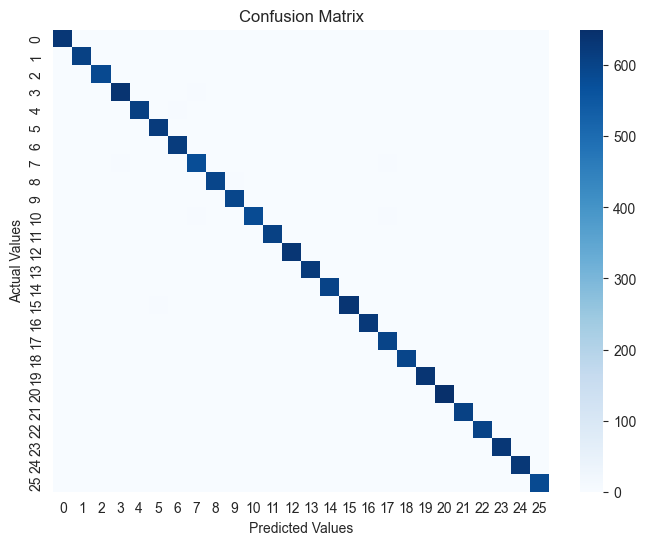

      Model  AUC        F1  Precision    Recall  \
0  SVC_None  NaN  0.996263   0.996268  0.996264   

                                         Best Params  
0  {'C': 1, 'class_weight': None, 'coef0': 0.5, '...  


In [22]:
tag, transform_list = transforms[0]
m, results = train_test_model(apply_transf_list(train, transform_list), y_train, model(), param_grid, results, tag)
best_models.append(m)

n_iterations: 5
n_required_iterations: 7
n_possible_iterations: 5
min_resources_: 156
max_resources_: 16000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1024
n_resources: 156
Fitting 3 folds for each of 1024 candidates, totalling 3072 fits
----------
iter: 1
n_candidates: 342
n_resources: 468
Fitting 3 folds for each of 342 candidates, totalling 1026 fits
----------
iter: 2
n_candidates: 114
n_resources: 1404
Fitting 3 folds for each of 114 candidates, totalling 342 fits
----------
iter: 3
n_candidates: 38
n_resources: 4212
Fitting 3 folds for each of 38 candidates, totalling 114 fits
----------
iter: 4
n_candidates: 13
n_resources: 12636
Fitting 3 folds for each of 13 candidates, totalling 39 fits
Model: SVC
AUC: nan
F1: 0.9853
Precision: 0.9854
Recall: 0.9853
Best Params: {'C': 10, 'class_weight': 'balanced', 'coef0': 0.0, 'degree': 5, 'gamma': 'scale', 'kernel': 'rbf'}


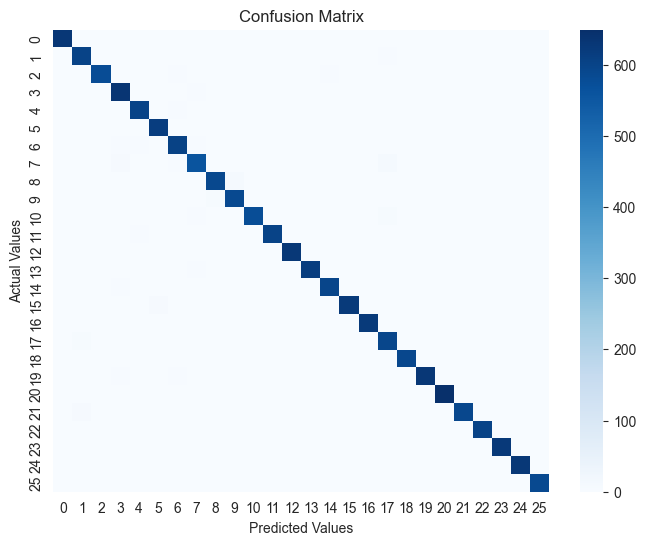

     Model  AUC        F1  Precision    Recall  \
0  SVC_PCA  NaN  0.985309   0.985432  0.985273   

                                         Best Params  
0  {'C': 10, 'class_weight': 'balanced', 'coef0':...  


In [23]:
tag, transform_list = transforms[1]
m, results = train_test_model(apply_transf_list(train, transform_list), y_train, model(), param_grid, results, tag)
best_models.append(m)

In [24]:
results

,Model,AUC,F1,Precision,Recall,Best Params
0,SVC_None,NaN,0.996263,0.996268,0.996264,"{'C': 1, 'class_weight': None, 'coef0': 0.5, '..."
1,SVC_PCA,NaN,0.985309,0.985432,0.985273,"{'C': 10, 'class_weight': 'balanced', 'coef0':..."


# Test

In [25]:
y_test = test['letter']
test.drop(['letter'],inplace=True, axis=1)

C:\Users\Danilo\AppData\Local\Temp\ipykernel_13384\2051681307.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(['letter'],inplace=True, axis=1)


Model: SVC
AUC: nan
F1: 0.9597
Precision: 0.9601
Recall: 0.9597


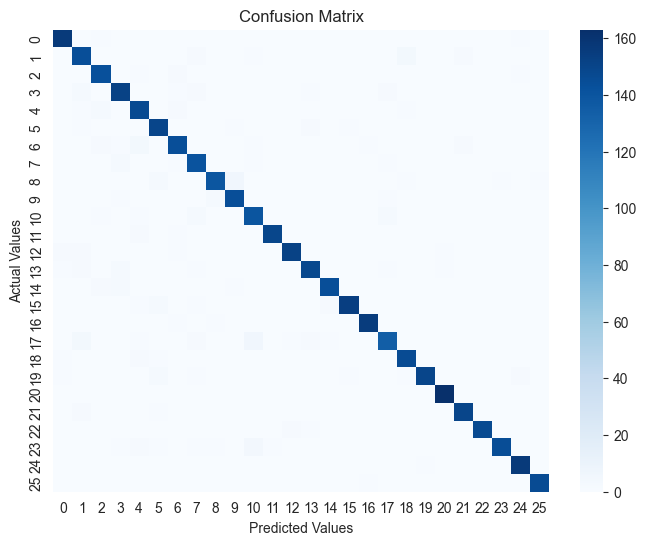

  Model  AUC        F1  Precision    Recall
0   SVC  NaN  0.959654   0.960126  0.959712


In [28]:
test_model(test, y_test, best_models[0])

Model: SVC
AUC: nan
F1: 0.9712
Precision: 0.9716
Recall: 0.9711


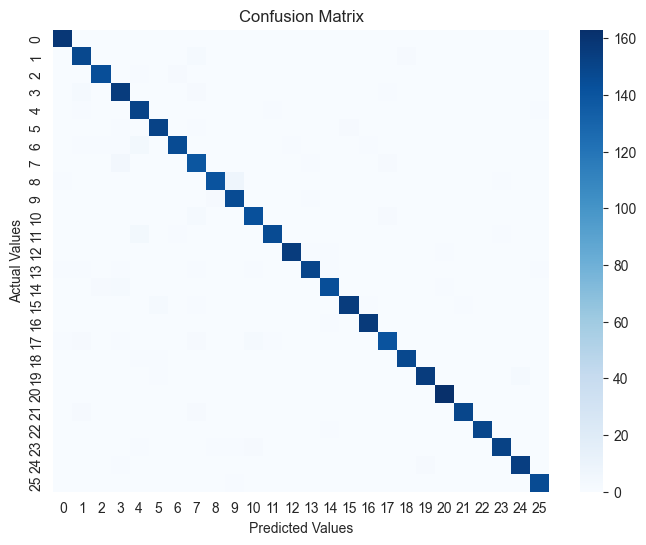

  Model  AUC        F1  Precision    Recall
0   SVC  NaN  0.971188   0.971574  0.971145


In [29]:
test_model(apply_transf_list(test, pca_transform_only), y_test, best_models[1])